In [1]:
import psycopg2
import pandas as pd
import numpy as np
import requests
import faiss
import time
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import json
import re
from typing import List
import logging

# =====================================
# 🔹 Global System Prompt (Shared by All Agents)
# =====================================
SYSTEM_PROMPT = (
    "Provide only the most relevant factual response in 3-4 sentences (max 350 characters). "
    "Do NOT include introductions, disclaimers, or statements about being an AI. "
    "Do NOT include personal beliefs, opinions, or subjective statements. "
    "Simply state the factual answer."
)

def clean_response(response_text: str) -> str:
    """Cleans AI-generated responses by removing common meta phrases."""
    remove_phrases = [
        "As an AI,", "I'm not capable of", "I cannot provide personal opinions",
        "Based on available information", "I can provide a factual response",
        "System: The given input", "The given text", "I believe", "I think",
        "It is possible that", "I've come to the conclusion that"
    ]
    for phrase in remove_phrases:
        response_text = re.sub(rf"(^|\b){re.escape(phrase)}", "", response_text, flags=re.IGNORECASE).strip()
    response_text = re.sub(r"^[,.\s]+", "", response_text)
    if response_text and response_text[0].islower():
        response_text = response_text.capitalize()
    return response_text

# =====================================
# 🔹 PostgreSQL Database Configuration
# =====================================
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# =====================================
# 🔹 Planning Taxonomy (Categories and Subcategories)
# =====================================
PLANNING_AGENTS = {
    "Planning Without Feedback": {
        "Single-Path Reasoning": ["Chain of Thought (CoT)", "Zero-Shot CoT", "Re-Prompting"],
        "Multi-Path Reasoning": ["ReWOO", "HuggingGPT", "Tree-of-Thought (ToT)"],
        "External Planner": ["LLM-Planner", "ReAct", "LLM+P"]
    },
    "Planning With Feedback": {
        "Environment Feedback": ["Inner Monologue", "LLM4RL"],
        "Human Feedback": ["ChatCoT", "TPTU"],
        "Model Feedback": ["Self-Refine", "SelfCheck"]
    }
}

def populate_planning_taxonomy():
    """
    Inserts planning categories and subcategories from PLANNING_AGENTS dictionary into the database.
    """
    with psycopg2.connect(**DB_CONFIG) as conn:
        with conn.cursor() as cursor:
            # Insert categories
            for category in PLANNING_AGENTS.keys():
                cursor.execute("""
                    INSERT INTO planning_categories (name)
                    VALUES (%s)
                    ON CONFLICT (name) DO NOTHING;
                """, (category,))
            conn.commit()
            # Insert subcategories
            for category, subcat_dict in PLANNING_AGENTS.items():
                cursor.execute("SELECT id FROM planning_categories WHERE name = %s;", (category,))
                cat_id = cursor.fetchone()[0]
                for subcategory in subcat_dict.keys():
                    cursor.execute("""
                        INSERT INTO planning_subcategories (name, category_id)
                        VALUES (%s, %s)
                        ON CONFLICT (name) DO NOTHING;
                    """, (subcategory, cat_id))
            conn.commit()
    print("✅ Planning taxonomy populated.")

# --------------------------------------
# Logging & Custom Cursor Setup
# --------------------------------------
logging.basicConfig(
    filename='executed_queries.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class LoggingCursor(psycopg2.extensions.cursor):
    def execute(self, sql, args=None):
        logging.info(self.mogrify(sql, args).decode('utf-8'))
        try:
            super().execute(sql, args)
        except Exception as e:
            logging.error(f"Error executing query: {e}")
            raise

# --------------------------------------
# drop_existing_table function
# --------------------------------------
def drop_existing_table():
    """Drops all related tables for a clean slate."""
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute("DROP TABLE IF EXISTS agent_pair_performance;")
            cursor.execute("DROP TABLE IF EXISTS task_performance;")
            cursor.execute("DROP TABLE IF EXISTS agents;")
            cursor.execute("DROP TABLE IF EXISTS planning_subcategories;")
            cursor.execute("DROP TABLE IF EXISTS planning_categories;")
            conn.commit()
    print("✅ Dropped existing tables.")

# --------------------------------------
# setup_database function
# --------------------------------------
def setup_database():
    """Creates necessary tables in the database."""
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            # planning_categories table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS planning_categories (
                    id SERIAL PRIMARY KEY,
                    name TEXT UNIQUE NOT NULL
                );
            """)
            # planning_subcategories table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS planning_subcategories (
                    id SERIAL PRIMARY KEY,
                    name TEXT UNIQUE NOT NULL,
                    category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE
                );
            """)
            # agents table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS agents (
                    id SERIAL PRIMARY KEY,
                    title TEXT UNIQUE NOT NULL,
                    profile TEXT,
                    memory TEXT,
                    planning_category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE,
                    planning_subcategory_id INT REFERENCES planning_subcategories(id) ON DELETE CASCADE,
                    action TEXT,
                    capability_acquisition TEXT,
                    social_science TEXT,
                    natural_science TEXT,
                    engineering TEXT,
                    subjective TEXT,
                    objective TEXT,
                    benchmark TEXT,
                    publication TEXT,
                    code_url TEXT,
                    paper_url TEXT,
                    generated_response TEXT[] DEFAULT ARRAY[]::TEXT[]
                );
            """)
            # task_performance table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS task_performance (
                    id SERIAL PRIMARY KEY,
                    task_name TEXT NOT NULL,
                    planning_category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE,
                    planning_subcategory_id INT REFERENCES planning_subcategories(id) ON DELETE CASCADE,
                    avg_euclidean_distance FLOAT,
                    avg_cosine_similarity FLOAT,
                    completion_time FLOAT,
                    response_length INT,
                    timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                );
            """)
            # agent_pair_performance table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS agent_pair_performance (
                    id SERIAL PRIMARY KEY,
                    task_name TEXT NOT NULL,
                    agent1 TEXT NOT NULL REFERENCES agents(title) ON DELETE CASCADE,
                    agent2 TEXT NOT NULL REFERENCES agents(title) ON DELETE CASCADE,
                    euclidean_distance FLOAT,
                    cosine_similarity FLOAT,
                    response_length FLOAT,
                    completion_time FLOAT,
                    timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    UNIQUE (task_name, agent1, agent2)
                );
            """)
            conn.commit()
    print("✅ Database setup completed.")

# --------------------------------------
# Insert Agents from CSV
# --------------------------------------
def insert_agents_from_csv(csv_filepath: str):
    """
    Reads agent data from a CSV file and inserts into the agents table.
    The CSV should have columns: Title, Profile, Memory, Planning, Action, Capability Acquition, 
    Social science, Natural Science, Engineering, Subjective, Objective, Benchmark, Publication, Code, Paper,
    and optionally Subcategory.
    """
    df = pd.read_csv(csv_filepath)
    df.columns = df.columns.str.strip()
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            for _, row in df.iterrows():
                try:
                    title = row["Title"].strip()
                    profile = row["Profile"].strip() if pd.notna(row["Profile"]) else None
                    memory = row["Memory"].strip() if pd.notna(row["Memory"]) else None
                    planning_text = row["Planning"].strip() if pd.notna(row["Planning"]) else "Unknown"
                    action = row["Action"].strip() if pd.notna(row["Action"]) else None
                    capability_acquisition = row["Capability Acquition"].strip() if pd.notna(row["Capability Acquition"]) else None
                    social_science = row["Social science"].strip() if pd.notna(row["Social science"]) else None
                    natural_science = row["Natural Science"].strip() if pd.notna(row["Natural Science"]) else None
                    engineering = row["Engineering"].strip() if pd.notna(row["Engineering"]) else None
                    subjective = row["Subjective"].strip() if pd.notna(row["Subjective"]) else None
                    objective = row["Objective"].strip() if pd.notna(row["Objective"]) else None
                    benchmark = row["Benchmark"].strip() if pd.notna(row["Benchmark"]) else None
                    publication = row["Publication"].strip() if pd.notna(row["Publication"]) else None
                    code_url = row["Code"].strip() if pd.notna(row["Code"]) else None
                    paper_url = row["Paper"].strip() if pd.notna(row["Paper"]) else None

                    # Look up planning category id
                    cursor.execute("SELECT id FROM planning_categories WHERE name = %s;", (planning_text,))
                    cat = cursor.fetchone()
                    planning_category_id = cat[0] if cat else None

                    # Optional: Look for a "Subcategory" column
                    planning_subcategory_id = None
                    if "Subcategory" in df.columns:
                        subcat_text = row["Subcategory"].strip() if pd.notna(row["Subcategory"]) else None
                        if subcat_text:
                            cursor.execute("SELECT id FROM planning_subcategories WHERE name = %s;", (subcat_text,))
                            subcat = cursor.fetchone()
                            if subcat:
                                planning_subcategory_id = subcat[0]
                    
                    cursor.execute("""
                        INSERT INTO agents (
                            title, profile, memory, planning_category_id, planning_subcategory_id,
                            action, capability_acquisition, social_science, natural_science, engineering,
                            subjective, objective, benchmark, publication, code_url, paper_url, generated_response
                        )
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, ARRAY[]::TEXT[])
                        ON CONFLICT (title) DO NOTHING;
                    """, (
                        title, profile, memory, planning_category_id, planning_subcategory_id,
                        action, capability_acquisition, social_science, natural_science, engineering,
                        subjective, objective, benchmark, publication, code_url, paper_url
                    ))
                    print(f"✅ Inserted: {title}")
                except Exception as e:
                    print(f"⚠️ Error inserting {row.get('Title', 'Unknown')}: {e}")
                    conn.rollback()
                else:
                    conn.commit()

# --------------------------------------
# Database Storage Functions for Agent Responses
# --------------------------------------
def update_generated_response(agent_title: str, new_response: str):
    """
    Appends a new response to the generated_response array for a specific agent.
    """
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute("SELECT id, generated_response FROM agents WHERE title = %s;", (agent_title,))
            result = cursor.fetchone()
            if result:
                agent_id = result[0]
                current_responses = result[1] if result[1] is not None else []
                print(f"Before update, generated_response for '{agent_title}': {current_responses}")
                cursor.execute(
                    "UPDATE agents SET generated_response = generated_response || %s::text[] WHERE id = %s;",
                    ([new_response], agent_id)
                )
                print(f"✅ Appended new response '{new_response}' to agent '{agent_title}'.")
            else:
                cursor.execute(
                    "INSERT INTO agents (title, generated_response) VALUES (%s, ARRAY[%s]::text[]) ON CONFLICT (title) DO NOTHING;",
                    (agent_title, new_response)
                )
                print(f"✅ Inserted new agent '{agent_title}' with initial response '{new_response}'.")
        conn.commit()

def store_agent_response(agent_name: str, response: str):
    """Stores or updates an agent's response in the database."""
    if isinstance(response, dict):
        response = json.dumps(response)
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute("SELECT generated_response FROM agents WHERE title = %s", (agent_name,))
            result = cursor.fetchone()
            if result:
                current_responses = result[0] or []
                if response not in current_responses:
                    cursor.execute("""
                        UPDATE agents 
                        SET generated_response = generated_response || ARRAY[%s]::text[]
                        WHERE title = %s
                    """, (response, agent_name))
                    print(f"✅ Response appended for agent: {agent_name} - {response}")
            else:
                cursor.execute("""
                    INSERT INTO agents (title, generated_response)
                    VALUES (%s, ARRAY[%s]::text[])
                """, (agent_name, response))
                print(f"✅ New response stored for agent: {agent_name} - {response}")
        conn.commit()

# --------------------------------------
# Generic Agent Function (LLM Call)
# --------------------------------------
def run_agent(agent_name: str, query_text: str, model: str) -> str:
    """
    Calls the LLM API for a given agent and updates the database with its response.
    """
    print(f"🤖 {agent_name} ({model}) is handling this query...")
    full_prompt = f"System: {SYSTEM_PROMPT}\nUser: {query_text}\nAssistant:"
    payload = {"model": model, "prompt": full_prompt, "stream": False}
    try:
        response = requests.post("http://localhost:11434/api/generate", json=payload)
        if response.status_code == 200:
            raw_response = response.json()
            print(f"🔍 Raw LLM Response ({agent_name}):", raw_response)
            answer = raw_response.get("response", "").strip()
            answer = clean_response(answer)
            if len(answer) > 350:
                answer = answer[:350] + "..."
            print(f"📝 {agent_name} Response: {answer}")
            if answer:
                update_generated_response(agent_name, answer)
            else:
                print(f"⚠️ Received an empty response from {agent_name} LLM.")
            return answer if answer else "No valid response received."
        else:
            print(f"❌ HTTP Error ({agent_name}): {response.status_code} - {response.text}")
    except Exception as e:
        print(f"❌ {agent_name} request failed: {str(e)}")
    return "No valid response received."

# --------------------------------------
# Individual Agent Functions (Wrappers)
# --------------------------------------
from langchain.prompts import PromptTemplate

def run_cot_langchain(query_text: str, model: str) -> str:
    return run_agent("Chain of Thought (CoT)", query_text, model)

def run_zero_shot_cot(query_text: str, model: str) -> str:
    print(f"🤖 Zero-Shot CoT ({model}) is handling this query with chain-of-thought reasoning (zero-shot)...")
    modified_query = query_text + " Let's think step by step."
    return run_agent("Zero-Shot CoT", modified_query, model)

def run_reprompting(query_text: str, model: str) -> str:
    base_instruction = "Please provide a detailed, step-by-step reasoning for your answer, verifying each step for correctness."
    initial_query = query_text + " " + base_instruction
    answer = run_agent("Re-Prompting", initial_query, model)
    if len(answer) < 50 or "step" not in answer.lower():
        refinement_instruction = "The previous response did not include enough step-by-step reasoning. Please re-generate your answer by breaking down the problem and validating each step explicitly."
        refined_query = query_text + " " + refinement_instruction
        answer = run_agent("Re-Prompting", refined_query, model)
    return answer

def run_rewoo(query_text: str, model: str) -> str:
    candidate_plan = run_agent("ReWOO", query_text, model)
    observation = "Observation: No anomalies detected in the environment."
    final_response = candidate_plan + " " + observation
    if len(final_response) > 350:
        final_response = final_response[:350] + "..."
    print(f"📝 ReWOO Final Response: {final_response}")
    update_generated_response("ReWOO", final_response)
    return final_response

def run_hugginggpt(query_text: str, model: str) -> str:
    decomposition_instruction = (
        " Please decompose the task into a series of sub-tasks. "
        "For each sub-task, indicate which HuggingFace model would be best suited to solve it, "
        "and then integrate the outcomes into a final concise answer."
    )
    modified_query = query_text + " " + decomposition_instruction
    return run_agent("HuggingGPT", modified_query, model)

def run_tree_of_thought(query_text: str, model: str) -> str:
    print(f"🤖 Tree-of-Thought (ToT) ({model}) is handling this query...")
    initial_prompt = (
        f"System: {SYSTEM_PROMPT}\nUser: {query_text}\nAssistant: "
        "Generate 3 distinct candidate reasoning steps to approach this problem, "
        "each on a separate line."
    )
    payload_init = {"model": model, "prompt": initial_prompt, "stream": False}
    try:
        response_init = requests.post("http://localhost:11434/api/generate", json=payload_init)
        if response_init.status_code == 200:
            raw_init = response_init.json()
            print("🔍 Raw initial candidate response (ToT):", raw_init)
            candidate_text = raw_init.get("response", "").strip()
            candidates = [clean_response(line) for line in candidate_text.split("\n") if line.strip()]
        else:
            print(f"❌ HTTP Error during candidate generation (ToT): {response_init.status_code} - {response_init.text}")
            candidates = []
    except Exception as e:
        print(f"❌ Candidate generation failed (ToT): {str(e)}")
        candidates = []
    if not candidates:
        final_response = "No valid chain of thought generated."
        update_generated_response("Tree-of-Thought (ToT)", final_response)
        return final_response
    expanded_candidates = []
    for candidate in candidates:
        expansion_prompt = (
            f"System: {SYSTEM_PROMPT}\nUser: Given the candidate reasoning step: '{candidate}', "
            "please expand it with additional detailed, step-by-step reasoning."
        )
        payload_exp = {"model": model, "prompt": expansion_prompt, "stream": False}
        try:
            response_exp = requests.post("http://localhost:11434/api/generate", json=payload_exp)
            if response_exp.status_code == 200:
                raw_exp = response_exp.json()
                print(f"🔍 Raw expansion for candidate '{candidate}':", raw_exp)
                expansion = raw_exp.get("response", "").strip()
                expansion = clean_response(expansion)
            else:
                print(f"❌ HTTP Error during candidate expansion: {response_exp.status_code} - {response_exp.text}")
                expansion = ""
        except Exception as e:
            print(f"❌ Expansion request failed for candidate '{candidate}': {str(e)}")
            expansion = ""
        full_candidate = candidate + " " + expansion
        expanded_candidates.append(full_candidate)
    best_candidate = max(expanded_candidates, key=len) if expanded_candidates else "No valid chain of thought generated."
    if len(best_candidate) > 350:
        best_candidate = best_candidate[:350] + "..."
    print(f"📝 Tree-of-Thought (ToT) Final Response: {best_candidate}")
    update_generated_response("Tree-of-Thought (ToT)", best_candidate)
    return best_candidate

def run_llm_planner(query_text: str, model: str) -> str:
    print(f"🤖 LLM-Planner ({model}) is handling the query with few-shot grounded planning...")
    import os, pickle
    knn_file = "knn_set.pkl"
    examples = []
    if os.path.exists(knn_file):
        try:
            with open(knn_file, "rb") as f:
                examples = pickle.load(f)
            print("✅ Loaded few-shot examples from knn_set.pkl.")
        except Exception as e:
            print(f"⚠️ Error loading knn_set.pkl: {str(e)}")
    if not examples:
        examples = [
            "Example 1: For planning a delivery route, first identify all delivery points; second, calculate the distances between them; third, determine an optimized route using a traveling salesman algorithm.",
            "Example 2: For a cooking task, list the required ingredients; then break down the recipe into sequential steps; finally, factor in cooking times and temperatures to schedule the process."
        ]
    header = f"System: {SYSTEM_PROMPT}\nBelow are some few-shot examples for planning:\n"
    few_shot_examples = "\n\n".join(examples)
    query_part = f"\n\nUser: {query_text}\nAssistant:"
    full_prompt = header + few_shot_examples + query_part
    payload = {"model": model, "prompt": full_prompt, "stream": False}
    try:
        response = requests.post("http://localhost:11434/api/generate", json=payload)
        if response.status_code == 200:
            raw_response = response.json()
            print("🔍 Raw LLM Response (LLM-Planner):", raw_response)
            answer = raw_response.get("response", "").strip()
            answer = clean_response(answer)
            if len(answer) > 350:
                answer = answer[:350] + "..."
            print(f"📝 LLM-Planner Response: {answer}")
            if answer:
                update_generated_response("LLM-Planner", answer)
            else:
                print("⚠️ Received an empty response from LLM-Planner LLM.")
            return answer if answer else "No valid response received."
        else:
            print(f"❌ HTTP Error (LLM-Planner): {response.status_code} - {response.text}")
    except Exception as e:
        print(f"❌ LLM-Planner request failed: {str(e)}")
    return "No valid response received."

def run_react(query_text: str, model: str) -> str:
    react_instruction = (
        " Please follow the ReAct protocol: Begin with a 'Thought:' section where you detail your reasoning. "
        "Then, decide on an 'Action:' to take based on your reasoning. Follow this with an 'Observation:' section "
        "to note the outcome, and finally provide your final answer. Keep the response concise and within 350 characters."
    )
    modified_query = query_text + " " + react_instruction
    return run_agent("ReAct", modified_query, model)

def run_llm_plus_p(query_text: str, model: str) -> str:
    pddl_instruction = (
        " Please translate the above task into a PDDL problem specification, "
        "simulate solving the problem with an external planner, "
        "and finally convert the generated plan back into a concise natural language answer."
    )
    modified_query = query_text + " " + pddl_instruction
    return run_agent("LLM+P", modified_query, model)

def run_inner_monologue(query_text: str, model: str) -> str:
    inner_monologue_instruction = (
        " Please provide an inner monologue of your reasoning. "
        "Describe your internal thought process step by step before arriving at your final concise answer."
    )
    modified_query = query_text + " " + inner_monologue_instruction
    return run_agent("Inner Monologue", modified_query, model)

def run_llm4rl(query_text: str, model: str) -> str:
    rl_instruction = (
        " Please generate an initial candidate plan for the above task. Then, simulate evaluating this plan "
        "using a reinforcement learning signal, and iteratively refine it to maximize the expected reward. "
        "Finally, output the refined plan in a concise format."
    )
    modified_query = query_text + " " + rl_instruction
    return run_agent("LLM4RL", modified_query, model)

def run_chatcot(query_text: str, model: str) -> str:
    feedback_instruction = (
        " First, generate a detailed chain-of-thought reasoning for the query. "
        "Then, reflect on your reasoning by checking each step for correctness. "
        "Finally, summarize your thought process and provide a concise final answer."
    )
    full_prompt = f"System: {SYSTEM_PROMPT}\nUser: {query_text} {feedback_instruction}\nAssistant:"
    payload = {"model": model, "prompt": full_prompt, "stream": False}
    try:
        response = requests.post("http://localhost:11434/api/generate", json=payload)
        if response.status_code == 200:
            raw_response = response.json()
            print("🔍 Raw LLM Response (ChatCoT):", raw_response)
            answer = raw_response.get("response", "").strip()
            answer = clean_response(answer)
            if len(answer) > 350:
                answer = answer[:350] + "..."
            print(f"📝 ChatCoT Response: {answer}")
            if answer:
                update_generated_response("ChatCoT", answer)
            else:
                print("⚠️ Received an empty response from ChatCoT LLM.")
            return answer if answer else "No valid response received."
        else:
            print(f"❌ HTTP Error (ChatCoT): {response.status_code} - {response.text}")
    except Exception as e:
        print(f"❌ ChatCoT request failed: {str(e)}")
    return "No valid response received."

def run_tptu(query_text: str, model: str) -> str:
    tptu_instruction = (
        " Please first provide an initial draft answer to the above query. Then, simulate receiving feedback "
        "from a human advisor on your draft answer, and iteratively refine your response based on that feedback. "
        "Finally, output your refined final answer in a concise manner."
    )
    modified_query = query_text + " " + tptu_instruction
    return run_agent("TPTU", modified_query, model)

def run_self_refine(query_text: str, model: str) -> str:
    print("🔹 Self-Refine: Generating initial answer...")
    initial_answer = run_agent("Self-Refine", query_text, model)
    refinement_instruction = (
        " Please review the initial answer provided above, and refine it to improve clarity, correctness, "
        "and conciseness. Ensure that the final answer is accurate and well-formulated."
    )
    refinement_query = query_text + " Initial Answer: " + initial_answer + " " + refinement_instruction
    print("🔹 Self-Refine: Generating refined answer...")
    refined_answer = run_agent("Self-Refine", refinement_query, model)
    return refined_answer

def run_selfcheck(query_text: str, model: str) -> str:
    print("🔹 SelfCheck: Generating initial answer...")
    initial_answer = run_agent("SelfCheck", query_text, model)
    print("🔹 SelfCheck: Reviewing the initial answer for errors...")
    selfcheck_instruction = (
        " Please review the initial answer provided above. "
        "Identify any errors, inconsistencies, or areas that require clarification. "
        "Then, generate a final corrected answer. "
        "If the initial answer is already accurate, confirm its correctness."
    )
    selfcheck_query = query_text + " Initial Answer: " + initial_answer + " " + selfcheck_instruction
    final_answer = run_agent("SelfCheck", selfcheck_query, model)
    return final_answer

# --------------------------------------
# Process Agents: Run All and Store Responses
# --------------------------------------
def process_agents(query_text: str, model: str):
    """Runs all planning agent functions and stores responses."""
    setup_database()
    populate_planning_taxonomy()
    
    agent_functions = {
        "Chain of Thought (CoT)": run_cot_langchain,
        "Zero-Shot CoT": run_zero_shot_cot,
        "Re-Prompting": run_reprompting,
        "ReWOO": run_rewoo,
        "HuggingGPT": run_hugginggpt,
        "Tree-of-Thought (ToT)": run_tree_of_thought,
        "LLM-Planner": run_llm_planner,
        "ReAct": run_react,
        "LLM+P": run_llm_plus_p,
        "Inner Monologue": run_inner_monologue,
        "LLM4RL": run_llm4rl,
        "ChatCoT": run_chatcot,
        "TPTU": run_tptu,
        "Self-Refine": run_self_refine,
        "SelfCheck": run_selfcheck,
    }
    responses = {}
    
    for agent_name, func in agent_functions.items():
        print(f"\n🔹 Processing {agent_name}...")
        response = func(query_text, model)
        responses[agent_name] = response if response else "No valid response received."
    
    for agent_name, response in responses.items():
        store_agent_response(agent_name, response)
    
    print("\n✅ Responses stored for all agents.")
    for agent_name, response in responses.items():
        print(f"✅ {agent_name} Response: {response}")

# --------------------------------------
# Semantic Search Functionality Using FAISS
# --------------------------------------
def semantic_search_responses(query: str, top_k: int = 3, embed_model_name: str = "all-MiniLM-L6-v2") -> List[str]:
    """
    Fetches all generated responses from the agents table, encodes them using SentenceTransformer,
    builds a FAISS index, and returns the top_k responses most similar to the query.
    """
    responses = []
    with psycopg2.connect(**DB_CONFIG) as conn:
        df = pd.read_sql("SELECT title, generated_response FROM agents", conn)
    for _, row in df.iterrows():
        if row["generated_response"]:
            responses.extend(row["generated_response"])
    if not responses:
        print("No responses found in the database.")
        return []
    embed_model = SentenceTransformer(embed_model_name)
    response_embeddings = embed_model.encode(responses, convert_to_numpy=True)
    d = response_embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(response_embeddings)
    query_embedding = embed_model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)
    top_responses = [responses[i] for i in indices[0]]
    return top_responses

# --------------------------------------
# Main Function (Entry Point)
# --------------------------------------
def main():
    model = "tinyllama"  # Using tinyllama for all agents
    query_text = "Provide a brief overview of quantum computing."
    csv_filepath = "agents.csv"  # Ensure this CSV exists and contains agent rows
    
    drop_existing_table()        # Drop all existing tables for a clean slate
    setup_database()             # Create new tables
    populate_planning_taxonomy() # Populate planning_categories and planning_subcategories
    insert_agents_from_csv(csv_filepath)  # Insert agents from CSV
    print("✅ Data insertion completed.")
    
    process_agents(query_text, model)
    
    search_query = "Which aspects of quantum computing are mentioned?"
    top_responses = semantic_search_responses(search_query, top_k=3)
    print("\n✅ Top responses from semantic search:")
    for res in top_responses:
        print(res)

if __name__ == "__main__":
    main()


/Users/gauraangmalik/.pyenv/versions/3.10.7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [4]:
import psycopg2
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import time

# =====================================
# 🔹 PostgreSQL Connection (New Project DB)
# =====================================
DB_CONFIG = {
    "dbname": "agents_db",           # New project database
    "user": "gauraangmalik",
    "password": "your_password",     # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# =====================================
# 🔹 Load SentenceTransformer Model for Vector Encoding
# =====================================
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# =====================================
# 🔹 Step 1: Retrieve & Process Responses from PostgreSQL
# =====================================
# Here, we unnest the generated_response array from the agents table.
# Adjust the WHERE clause if you want to select a different set of agents.
conn = psycopg2.connect(**DB_CONFIG)
query = """
SELECT title, t.response, t.idx
FROM agents
CROSS JOIN LATERAL unnest(generated_response) WITH ORDINALITY AS t(response, idx)
WHERE title IN ('SmolAgents', 'AutoGen', 'Reflexion', 'ChatCoT', 'Chain of Thought (CoT)', 'Zero-Shot CoT', 'Re-Prompting', 'ReWOO', 'HuggingGPT', 'Tree-of-Thought (ToT)', 'LLM-Planner', 'ReAct', 'LLM+P', 'Inner Monologue', 'LLM4RL', 'TPTU', 'Self-Refine', 'SelfCheck')
ORDER BY t.idx;
"""
df = pd.read_sql(query, conn)
conn.close()

# =====================================
# 🔹 Step 2: Group Responses by Ordinality (Index)
# =====================================
# Each unnest index (idx) represents a particular "batch" or task iteration.
grouped_responses = defaultdict(dict)  # Dictionary mapping index -> {agent_title: response}
for _, row in df.iterrows():
    # Group responses by the ordinal index 'idx'
    grouped_responses[row['idx']][row['title']] = row['response']

# =====================================
# 🔹 Step 3: Convert Text Responses to Vectors & Store in FAISS Indexes
# =====================================
# We'll create a separate FAISS index for each vector space (i.e. each idx).
faiss_indexes = {}  # Dictionary mapping idx -> FAISS index
for idx, response_dict in grouped_responses.items():
    print(f"\n🔹 Processing Vector Space (idx) {idx}...")
    agent_names = list(response_dict.keys())
    responses = list(response_dict.values())
    # Skip vector spaces with fewer than 2 responses (cannot compare if only one exists)
    if len(responses) < 2:
        print(f"⚠️ Skipping Vector Space {idx} - Not enough responses.")
        continue
    # Convert text responses to embeddings using the SentenceTransformer model.
    embeddings = embed_model.encode(responses, convert_to_numpy=True)
    # 'dimension' is the size of each embedding vector.
    dimension = embeddings.shape[1]
    if idx not in faiss_indexes:
        faiss_indexes[idx] = faiss.IndexFlatL2(dimension)
    # Add vectors to the FAISS index.
    if faiss_indexes[idx].ntotal == 0:
        faiss_indexes[idx].add(np.array(embeddings, dtype=np.float32))
        print(f"✅ Stored {len(responses)} responses in Vector Space {idx}")

# =====================================
# 🔹 Step 4: Similarity Computation and Convergence Assessment
# =====================================
def check_stability(euclidean_distance, cos_sim, agent_pair, vector_space_id):
    """
    Determines if the agents are converging (Stable), diverging (Need Human Feedback), or partially in agreement (Mixed).
    THRESHOLD NOTE: Adjust these threshold values later based on empirical results.
    """
    if euclidean_distance < 0.3 and cos_sim > 0.9:
        status = f"✅ {agent_pair} are converging (Stable)"
    elif euclidean_distance > 1.0 and cos_sim < 0.5:
        status = f"❌ {agent_pair} are diverging (Need Human Feedback)"
    else:
        status = f"🔄 {agent_pair} have partial agreement (Mixed)"
    
    print(f"🔹 Stability Status for {agent_pair} in Vector Space {vector_space_id}: {status}\n")

def compute_similarity(vector_space_id):
    """
    Computes both Euclidean Distance and Cosine Similarity between responses from different agents
    in a given vector space (identified by idx).
    """
    if vector_space_id not in faiss_indexes:
        print(f"⚠️ No FAISS index found for Vector Space {vector_space_id}.")
        return
    index = faiss_indexes[vector_space_id]
    num_vectors = index.ntotal
    if num_vectors < 2:
        print(f"⚠️ Not enough responses in Vector Space {vector_space_id} to compute similarity.")
        return
    print(f"🔍 Computing similarity for Vector Space {vector_space_id}...")
    # Retrieve stored vectors from the FAISS index.
    stored_vectors = np.zeros((num_vectors, index.d), dtype=np.float32)
    for i in range(num_vectors):
        index.reconstruct(i, stored_vectors[i])
    # Dynamically map agent names to their vectors.
    agent_names = list(grouped_responses[vector_space_id].keys())
    vector_map = {agent_names[i]: stored_vectors[i] for i in range(num_vectors)}
    # Compute pairwise similarities for each unique agent pair.
    agent_pairs = [(a, b) for i, a in enumerate(agent_names) for b in agent_names[i+1:]]
    for agent_a, agent_b in agent_pairs:
        v1, v2 = vector_map[agent_a], vector_map[agent_b]
        euclidean_distance = np.linalg.norm(v1 - v2)
        cos_sim = cosine_similarity([v1], [v2])[0][0]
        print(f"✅ Euclidean Distance ({agent_a} ↔ {agent_b}): {euclidean_distance:.4f}")
        print(f"✅ Cosine Similarity ({agent_a} ↔ {agent_b}): {cos_sim:.4f}")
        check_stability(euclidean_distance, cos_sim, f"{agent_a} ↔ {agent_b}", vector_space_id)

# =====================================
# 🔹 Step 5: Run Similarity Computation for Each Vector Space
# =====================================
for vector_space_id in grouped_responses.keys():
    compute_similarity(vector_space_id)
print("\n🚀 All vector spaces processed successfully!")

# =====================================
# 🔹 New Step: Compute Task Performance Metrics and Save to Database
# =====================================
def compute_task_performance(vector_space_id):
    """
    Computes overall performance metrics for a given vector space (task iteration):
      - Average Euclidean distance (avg_euclidean_distance)
      - Average cosine similarity (avg_cosine_similarity)
      - Evaluation score (evaluation_score) as the sum of the above averages (placeholder)
      - Average response length (response_length)
      - Completion time (completion_time) for processing this vector space.
    Note: Thresholds and evaluation formula might need adjustment.
    """
    start_time = time.time()
    if vector_space_id not in faiss_indexes:
        print(f"⚠️ No FAISS index for Vector Space {vector_space_id}.")
        return None
    index = faiss_indexes[vector_space_id]
    num_vectors = index.ntotal
    if num_vectors < 2:
        print(f"⚠️ Not enough responses in Vector Space {vector_space_id} for performance computation.")
        return None
    # Reconstruct stored vectors.
    stored_vectors = np.zeros((num_vectors, index.d), dtype=np.float32)
    for i in range(num_vectors):
        index.reconstruct(i, stored_vectors[i])
    # Compute response lengths.
    responses = list(grouped_responses[vector_space_id].values())
    response_lengths = [len(r) for r in responses]
    # Compute pairwise distances and cosine similarities.
    distances = []
    cosine_sims = []
    for i in range(num_vectors):
        for j in range(i+1, num_vectors):
            d = np.linalg.norm(stored_vectors[i] - stored_vectors[j])
            cs = cosine_similarity([stored_vectors[i]], [stored_vectors[j]])[0][0]
            distances.append(d)
            cosine_sims.append(cs)
    if distances and cosine_sims:
        avg_distance = np.mean(distances)
        avg_cos_sim = np.mean(cosine_sims)
    else:
        avg_distance = avg_cos_sim = 0
    avg_response_length = np.mean(response_lengths) if response_lengths else 0
    completion_time = time.time() - start_time
    return {
        "avg_euclidean_distance": avg_distance,
        "avg_cosine_similarity": avg_cos_sim,
        "response_length": avg_response_length,
        "completion_time": completion_time
    }

def save_task_performance(task_name, performance):
    """
    Saves the computed performance metrics into the task_performance table.
    The task_name is typically the ordinal index (converted to string) for this vector space.
    """
    insert_sql = """
    INSERT INTO task_performance 
      (task_name, avg_euclidean_distance, avg_cosine_similarity, , response_length, completion_time)
    VALUES (%s, %s, %s, %s, %s, %s)
    ON CONFLICT (task_name)
    DO UPDATE SET
      avg_euclidean_distance = EXCLUDED.avg_euclidean_distance,
      avg_cosine_similarity = EXCLUDED.avg_cosine_similarity,
      response_length = EXCLUDED.response_length,
      completion_time = EXCLUDED.completion_time;
    """
    params = (
        task_name,
        float(performance["avg_euclidean_distance"]),
        float(performance["avg_cosine_similarity"]),
        float(performance["response_length"]),
        float(performance["completion_time"]) if performance["completion_time"] is not None else None
    )
    # Print the SQL and parameters for debugging
    print("Executing SQL:")
    print(insert_sql)
    print("With parameters:")
    print(params)
    
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        df_perf = pd.read_sql("SELECT * FROM task_performance ORDER BY task_name;", conn)
    print("Stored task performance records:")
    print(df_perf)




# Loop through each vector space and save performance metrics.
for vector_space_id in grouped_responses.keys():
    performance = compute_task_performance(vector_space_id)
    if performance is not None:
        # Here, we use the vector_space_id as the task_name.
        save_task_performance(str(vector_space_id), performance)

# =====================================
# 🔹 Additional: Fetch and Clean Data from the Database
# =====================================
def fetch_and_clean_responses():
    """
    Fetches responses from the agents table and removes empty responses.
    Saves the cleaned data to a CSV file.
    
    Returns:
        DataFrame: The cleaned responses DataFrame.
    """
    conn = psycopg2.connect(**DB_CONFIG)
    query = """
    SELECT title, t.response, t.idx, profile, memory, action,
           capability_acquisition, social_science, natural_science, engineering, benchmark
    FROM agents
    CROSS JOIN LATERAL unnest(generated_response) WITH ORDINALITY AS t(response, idx)
    ORDER BY t.idx;
    """
    df = pd.read_sql(query, conn)
    conn.close()
    # Remove rows with empty or NaN responses.
    df_filtered = df[df["response"].notna() & (df["response"].str.strip() != "")]
    print(f"\n✅ Original Data: {df.shape[0]} rows")
    print(f"✅ Cleaned Data: {df_filtered.shape[0]} rows (Removed {df.shape[0] - df_filtered.shape[0]} empty responses)\n")
    # Optionally, save cleaned responses to CSV.
    df_filtered.to_csv("cleaned_agent_responses.csv", index=False)
    print("✅ Cleaned responses saved as 'cleaned_agent_responses.csv'.")
    return df_filtered

# Execute the cleaning function
cleaned_df = fetch_and_clean_responses()


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_38297/3029481612.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



🔹 Processing Vector Space (idx) 1...


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


✅ Stored 15 responses in Vector Space 1

🔹 Processing Vector Space (idx) 2...


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.95it/s]
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_38297/3029481612.py:212: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perf = pd.read_sql("SELECT * FROM task_performance ORDER BY task_name;", conn)


✅ Stored 4 responses in Vector Space 2
🔍 Computing similarity for Vector Space 1...
✅ Euclidean Distance (Chain of Thought (CoT) ↔ Zero-Shot CoT): 0.6603
✅ Cosine Similarity (Chain of Thought (CoT) ↔ Zero-Shot CoT): 0.7820
🔹 Stability Status for Chain of Thought (CoT) ↔ Zero-Shot CoT in Vector Space 1: 🔄 Chain of Thought (CoT) ↔ Zero-Shot CoT have partial agreement (Mixed)

✅ Euclidean Distance (Chain of Thought (CoT) ↔ TPTU): 0.6253
✅ Cosine Similarity (Chain of Thought (CoT) ↔ TPTU): 0.8045
🔹 Stability Status for Chain of Thought (CoT) ↔ TPTU in Vector Space 1: 🔄 Chain of Thought (CoT) ↔ TPTU have partial agreement (Mixed)

✅ Euclidean Distance (Chain of Thought (CoT) ↔ Re-Prompting): 0.7083
✅ Cosine Similarity (Chain of Thought (CoT) ↔ Re-Prompting): 0.7491
🔹 Stability Status for Chain of Thought (CoT) ↔ Re-Prompting in Vector Space 1: 🔄 Chain of Thought (CoT) ↔ Re-Prompting have partial agreement (Mixed)

✅ Euclidean Distance (Chain of Thought (CoT) ↔ LLM4RL): 0.5229
✅ Cosine Simil

/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_38297/3029481612.py:212: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perf = pd.read_sql("SELECT * FROM task_performance ORDER BY task_name;", conn)
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_38297/3029481612.py:245: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_38297/3291266403.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Data Fetched Successfully!
                    title                                           response  \
0  Chain of Thought (CoT)  Factually response: Quantum computing is a fie...   
1           Zero-Shot CoT  Brief Overview of Quantum Computing:\n\nQuantu...   
2                    TPTU  Answer: Quantum computing refers to the use of...   
3            Re-Prompting  Factually answering "What is Quantum Computing...   
4                  LLM4RL  Factual response: Quantum computing is a revol...   

   idx  
0    1  
1    1  
2    1  
3    1  
4    1  


Batches: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]



🔹 Task 1: PCA Output Shape = (15, 2)

🔹 Task 2: PCA Output Shape = (4, 2)
✅ Task Matrix CSV saved.

🔹 Computing Cosine Similarity Between Agents...

  ✅ Chain of Thought (CoT) (Task 1): Vector Sum = 1.1291
  ✅ ChatCoT (Task 1): Vector Sum = 0.5516
  ✅ HuggingGPT (Task 1): Vector Sum = 1.1035
  ✅ Inner Monologue (Task 1): Vector Sum = 0.5600
  ✅ LLM+P (Task 1): Vector Sum = 1.0826
  ✅ LLM-Planner (Task 1): Vector Sum = 1.1206
  ✅ LLM4RL (Task 1): Vector Sum = 0.8020
  ✅ Re-Prompting (Task 1): Vector Sum = 1.1756
  ✅ ReAct (Task 1): Vector Sum = 1.1325
  ✅ ReWOO (Task 1): Vector Sum = 1.1692
  ✅ Self-Refine (Task 1): Vector Sum = 0.0625
  ✅ SelfCheck (Task 1): Vector Sum = 0.3162
  ✅ TPTU (Task 1): Vector Sum = 1.2702
  ✅ Tree-of-Thought (ToT) (Task 1): Vector Sum = 1.0388
  ✅ Zero-Shot CoT (Task 1): Vector Sum = 0.9647
  ✅ Re-Prompting (Task 2): Vector Sum = 1.1920
  ✅ ReWOO (Task 2): Vector Sum = 1.1692
  ✅ Self-Refine (Task 2): Vector Sum = 0.4906
  ✅ SelfCheck (Task 2): Vector Sum =

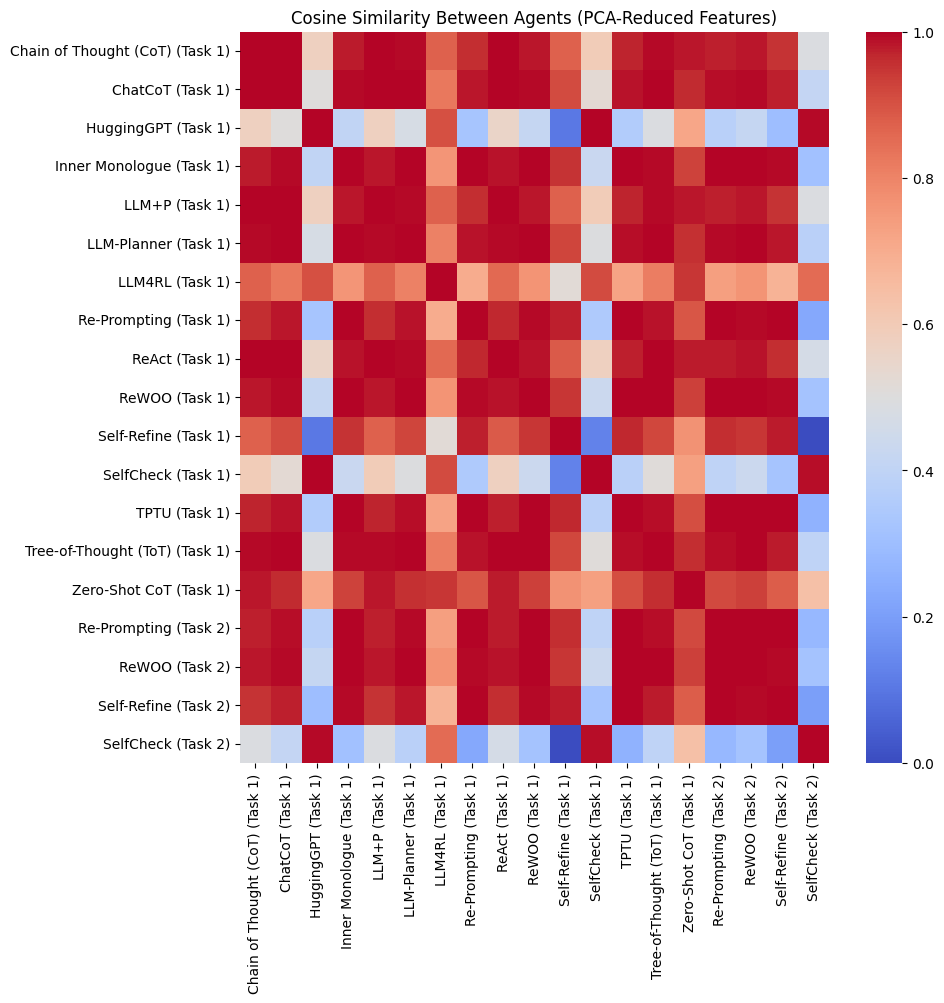

Euclidean Distance Matrix:
[[0.         0.4154214  0.8571222  0.4030246  0.03387466 0.10781828
  0.42898485 0.2944651  0.02275951 0.18880679 0.77511287 0.6981074
  0.30959153 0.09404121 0.19833611 0.2454142  0.18880679 0.45158193
  0.806064  ]
 [0.4154214  0.         0.8728218  0.05515581 0.38160118 0.44232005
  0.33557263 0.57504904 0.4224695  0.50968033 0.36073312 0.36064646
  0.62811226 0.37385145 0.30406344 0.55306584 0.50968033 0.09304647
  0.39904225]
 [0.8571222  0.8728218  0.         0.9197123  0.8490451  0.9646529
  0.5395624  1.1506901  0.87980485 1.0446384  1.0008374  0.7226593
  1.1560491  0.9270759  0.70313746 1.1000688  1.0446384  0.9658533
  0.9566224 ]
 [0.4030246  0.05515581 0.9197123  0.         0.3697859  0.41685307
  0.3805546  0.5367054  0.40721464 0.47835085 0.38537368 0.4125118
  0.59249806 0.3504354  0.3182862  0.51840043 0.47835085 0.05630408
  0.43171814]
 [0.03387466 0.38160118 0.8490451  0.3697859  0.         0.11873467
  0.40516415 0.3077452  0.04673811 0.2

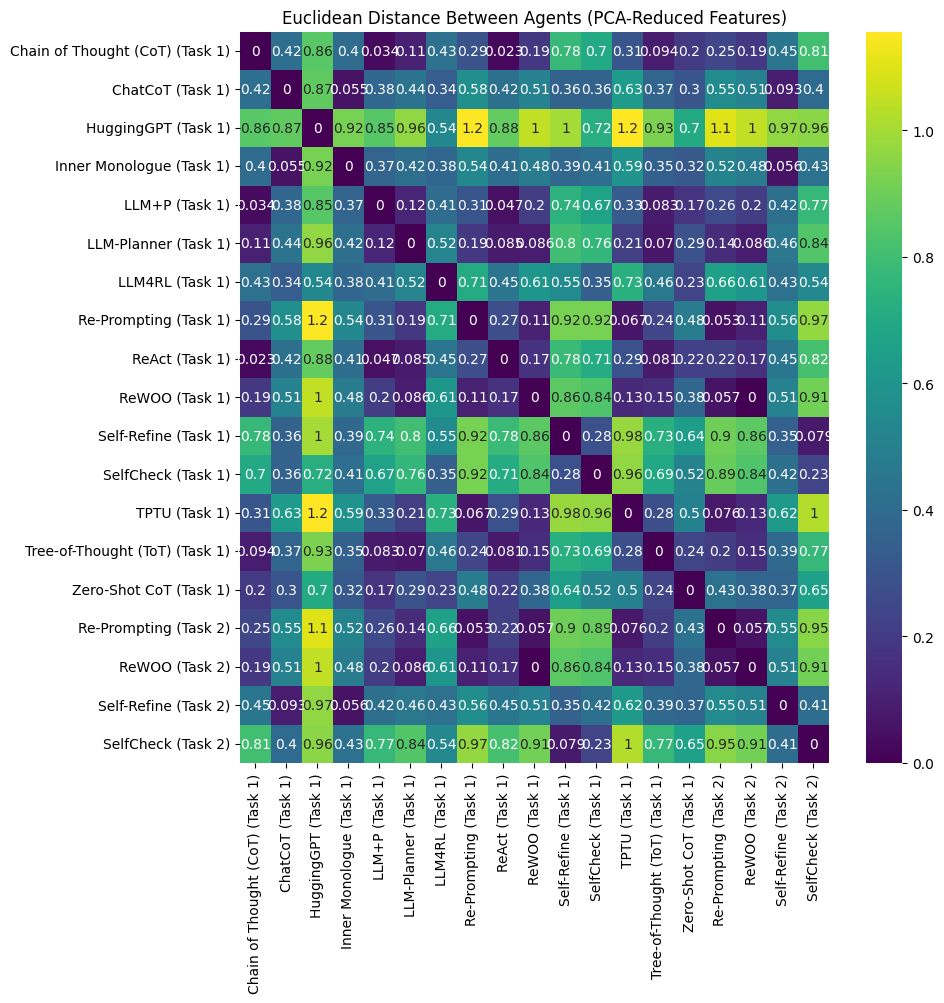

Executing SQL:

    INSERT INTO agent_pair_performance
      (task_name, agent1, agent2, euclidean_distance, cosine_similarity, evaluation_score, response_length, completion_time)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (task_name, agent1, agent2)
    DO UPDATE SET
      euclidean_distance = EXCLUDED.euclidean_distance,
      cosine_similarity = EXCLUDED.cosine_similarity,
      evaluation_score = EXCLUDED.evaluation_score,
      response_length = EXCLUDED.response_length,
      completion_time = EXCLUDED.completion_time;
    
With parameters:
('1', 'Chain of Thought (CoT)', 'Zero-Shot CoT', 0.19833610951900482, 0.9836198091506958, 1.1819559335708618, 353.0, 0.00030994415283203125)


UndefinedColumn: column "evaluation_score" of relation "agent_pair_performance" does not exist
LINE 3: ...1, agent2, euclidean_distance, cosine_similarity, evaluation...
                                                             ^


In [6]:
import psycopg2
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import time

# PostgreSQL connection config
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",
    "host": "localhost",
    "port": 5432
}

embed_model = SentenceTransformer('all-MiniLM-L6-v2')

def fetch_task_responses():
    """
    Retrieve generated responses from the agents table, unnesting the generated_response array.
    """
    with psycopg2.connect(**DB_CONFIG) as conn:
        query = """
        SELECT title, t.response, t.idx
        FROM agents
        CROSS JOIN LATERAL unnest(generated_response) WITH ORDINALITY AS t(response, idx)
        ORDER BY t.idx;
        """
        df = pd.read_sql(query, conn)
    return df

df = fetch_task_responses()
print("✅ Data Fetched Successfully!")
print(df.head())


# ===============================
# 🔹 3) Group Responses by Task (Index)
# ===============================
grouped_responses = defaultdict(dict)  # { idx -> { agent_title: response } }
for _, row in df.iterrows():
    grouped_responses[row['idx']][row['title']] = row['response']

# ===============================
# 🔹 4) Global Encoding: PCA & Normalization
# ===============================
# Extract all responses into a list
all_responses = df["response"].tolist()

# Convert them to embeddings
all_embeddings = embed_model.encode(all_responses, convert_to_numpy=True)

# Optional global minmax scaling
scaler_global = MinMaxScaler()
all_embeddings_scaled = scaler_global.fit_transform(all_embeddings)

# PCA to reduce to 2D
pca_n_components = min(2, all_embeddings_scaled.shape[1])
pca = PCA(n_components=pca_n_components)
pca.fit(all_embeddings_scaled)

pca_embeddings = pca.transform(all_embeddings_scaled)

# (Optional) Another minmax scale after PCA
scaler_pca = MinMaxScaler()
pca_embeddings_scaled = scaler_pca.fit_transform(pca_embeddings)

# ===============================
# 🔹 5) Compute Task Rankings Using Fixed PCA - task_matrix = task_titles and task_responses
# ===============================
# We'll build a task matrix that stores, for each task (idx) and each agent,
# a "Reduced Vector" (the PCA embedding) and a "Total Score" computed as the sum of the absolute values.
task_matrix = defaultdict(dict)
unique_tasks = df["idx"].unique()

for task_id in unique_tasks:
    # Subset to this task
    task_data = df[df["idx"] == task_id]
    task_titles = task_data["title"].tolist()
    task_responses = task_data["response"].tolist()

    # Indices in the all_responses list
    response_indices = [all_responses.index(resp) for resp in task_responses]
    reduced_vectors = pca_embeddings_scaled[response_indices]

    print(f"\n🔹 Task {task_id}: PCA Output Shape = {reduced_vectors.shape}")

    for i, title in enumerate(task_titles):
        if i >= len(reduced_vectors):
            continue
        vector = reduced_vectors[i]

        # For demonstration, total_score = sum(abs(vector))
        total_score = np.sum(np.abs(vector))

        task_matrix[task_id][title] = {
            "Total Score": total_score,
            "Reduced Vector": vector
        }

# (Optional) Remove zero vectors
for tid in list(task_matrix.keys()):
    for agent in list(task_matrix[tid].keys()):
        if np.all(task_matrix[tid][agent]["Reduced Vector"] == 0):
            del task_matrix[tid][agent]


# ===============================
# 🔹 6) Save Task Matrix to CSV
# ===============================
task_matrix_df = pd.DataFrame.from_dict(
    {(t, agent): task_matrix[t][agent] 
     for t in task_matrix.keys() for agent in task_matrix[t].keys()},
    orient='index'
).reset_index()
task_matrix_df.rename(columns={"level_0": "Task", "level_1": "Agent"}, inplace=True)
task_matrix_df.to_csv("normalized_task_matrix_fixed.csv", index=False)
print("✅ Task Matrix CSV saved.")


# ===============================
# 🔹 7) Compute Cosine Similarity & Euclidean Distance & Plot Heatmap
# ===============================
print("\n🔹 Computing Cosine Similarity Between Agents...\n")
valid_vectors = []
valid_agents = []

for task_id in sorted(task_matrix.keys()):
    for agent in sorted(task_matrix[task_id].keys()):
        vector = task_matrix[task_id][agent].get("Reduced Vector", None)
        if vector is not None and np.any(vector):
            valid_agents.append(f"{agent} (Task {task_id})")
            valid_vectors.append(vector)
            print(f"  ✅ {agent} (Task {task_id}): Vector Sum = {np.sum(vector):.4f}")
        else:
            print(f"  ❌ {agent} (Task {task_id}): No valid response")

if len(valid_agents) < 2:
    print("\n⚠️ Not enough valid responses to compute similarity. At least 2 are required.")
else:
    valid_vectors = np.array(valid_vectors)
    similarity_matrix = cosine_similarity(valid_vectors)

    num_agents = len(valid_agents)
    plt.figure(figsize=(min(15, num_agents / 2), min(12, num_agents / 2)))
    sns.heatmap(
        similarity_matrix,
        annot=False,
        cmap="coolwarm",
        xticklabels=valid_agents if num_agents < 40 else valid_agents[::2],
        yticklabels=valid_agents if num_agents < 40 else valid_agents[::2]
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Cosine Similarity Between Agents (PCA-Reduced Features)")
    plt.show()

# After your cosine similarity block, add:

if len(valid_agents) < 2:
    print("\n⚠️ Not enough valid responses to compute Euclidean distances. At least 2 are required.")
else:
    # Compute Euclidean distance matrix using broadcasting:
    euclidean_matrix = np.sqrt(((valid_vectors[:, np.newaxis] - valid_vectors) ** 2).sum(axis=2))
    
    # Print the Euclidean matrix for inspection
    print("Euclidean Distance Matrix:")
    print(euclidean_matrix)
    
    # Plot the Euclidean distance matrix as a heatmap.
    plt.figure(figsize=(min(15, num_agents / 2), min(12, num_agents / 2)))
    sns.heatmap(
        euclidean_matrix,
        annot=True,  # Set to True to display distance values on the heatmap
        cmap="viridis",  # You can choose another colormap if preferred
        xticklabels=valid_agents if num_agents < 40 else valid_agents[::2],
        yticklabels=valid_agents if num_agents < 40 else valid_agents[::2]
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Euclidean Distance Between Agents (PCA-Reduced Features)")
    plt.show()



# ===============================
# 🔹 6) Compute Pair Performance
# ===============================
def compute_pair_performance(vector1, vector2, response1, response2):
    """
    Computes performance metrics for a pair of responses:
      - euclidean_distance: L2 norm between the two vectors.
      - cosine_similarity: Cosine similarity between the two vectors.
      - evaluation_score: Sum of the two metrics (placeholder; adjust as needed).
      - response_length: Average length of the two responses.
      - completion_time: Time taken to compute these metrics.
    """
    start_time = time.time()
    euclidean_distance = np.linalg.norm(vector1 - vector2)
    cos_sim = cosine_similarity([vector1], [vector2])[0][0]
    evaluation_score = euclidean_distance + cos_sim  # Placeholder formula
    avg_response_length = (len(response1) + len(response2)) / 2.0
    completion_time = time.time() - start_time

    return {
        "euclidean_distance": float(euclidean_distance),
        "cosine_similarity": float(cos_sim),
        "evaluation_score": float(evaluation_score),
        "response_length": float(avg_response_length),
        "completion_time": completion_time
    }

# ===============================
# 🔹 Save Agent Pair Performance
# ===============================
def save_pair_performance(task_name, agent1, agent2, performance):
    """
    Saves performance metrics for an agent pair into the agent_pair_performance table.
    Assumes that (task_name, agent1, agent2) is unique.
    """
    insert_sql = """
    INSERT INTO agent_pair_performance
      (task_name, agent1, agent2, euclidean_distance, cosine_similarity, evaluation_score, response_length, completion_time)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (task_name, agent1, agent2)
    DO UPDATE SET
      euclidean_distance = EXCLUDED.euclidean_distance,
      cosine_similarity = EXCLUDED.cosine_similarity,
      evaluation_score = EXCLUDED.evaluation_score,
      response_length = EXCLUDED.response_length,
      completion_time = EXCLUDED.completion_time;
    """
    params = (
        str(task_name),
        agent1,
        agent2,
        performance["euclidean_distance"],
        performance["cosine_similarity"],
        performance["evaluation_score"],
        performance["response_length"],
        performance["completion_time"]
    )
    print("Executing SQL:")
    print(insert_sql)
    print("With parameters:")
    print(params)
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute(insert_sql, params)
        conn.commit()
    print(f"✅ Saved performance for task {task_name} between {agent1} and {agent2}.")

def process_pair_performance(grouped_responses, task_matrix):
    """
    Loops over each task iteration and for each unique pair of agents in that task,
    computes performance metrics and saves them to the agent_pair_performance table.
    """
    for task_id in sorted(grouped_responses.keys()):
        responses_dict = grouped_responses[task_id]
        agents = list(responses_dict.keys())
        # Ensure at least two agents provided a response.
        if len(agents) < 2:
            continue
        for i in range(len(agents)):
            for j in range(i + 1, len(agents)):
                agent1 = agents[i]
                agent2 = agents[j]
                if agent1 in task_matrix[task_id] and agent2 in task_matrix[task_id]:
                    vector1 = task_matrix[task_id][agent1]["Reduced Vector"]
                    vector2 = task_matrix[task_id][agent2]["Reduced Vector"]
                    response1 = responses_dict[agent1]
                    response2 = responses_dict[agent2]
                    performance = compute_pair_performance(vector1, vector2, response1, response2)
                    save_pair_performance(task_id, agent1, agent2, performance)

    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute(insert_sql, params)
        conn.commit()
    print(f"✅ Saved performance for task {task_id} between {agent1} and {agent2}.")

# ===============================
# 🔹 7) Loop Over Each Task Iteration and Compute Pairwise Performance
# ===============================
for task_id in sorted(grouped_responses.keys()):
    responses_dict = grouped_responses[task_id]  # {agent_title: response}
    agents = list(responses_dict.keys())
    # Ensure at least two agents provided a response for this task.
    if len(agents) < 2:
        continue
    # Loop over all unique pairs of agents.
    for i in range(len(agents)):
        for j in range(i + 1, len(agents)):
            agent1 = agents[i]
            agent2 = agents[j]
            # Retrieve PCA-reduced vectors from your task_matrix.
            # (Ensure that agent names in task_matrix match those in grouped_responses.)
            if agent1 in task_matrix[task_id] and agent2 in task_matrix[task_id]:
                vector1 = task_matrix[task_id][agent1]["Reduced Vector"]
                vector2 = task_matrix[task_id][agent2]["Reduced Vector"]
                response1 = responses_dict[agent1]
                response2 = responses_dict[agent2]
                
                performance = compute_pair_performance(vector1, vector2, response1, response2)
                save_pair_performance(task_id, agent1, agent2, performance)
            else:
                print(f"❌ Missing reduced vector for {agent1} or {agent2} in task {task_id}")

# ===============================
# 🔹 8) Display Stored Performance Tables
# ===============================
# Connect to the database and read the agent_pair_performance table into a DataFrame.
with psycopg2.connect(**DB_CONFIG) as conn:
    df_agent_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Table:")
print(df_agent_pair)




planning_categories
id	name
1	Planning Without Feedback
2	Planning With Feedback

planning_subcategories
id	name	category_id
1	Single-Path Reasoning	1
2	Multi-Path Reasoning	1
3	External Planner	1
4	Environment Feedback	2
5	Human Feedback	2
6	Model Feedback	2

id	title	profile	memory	...	generated_response
1	Chain of Thought (CoT)	Some profile...	Some mem	...	{ "The train's speed is 60 km/h", "Computed as 120/2" }
2	Zero-Shot CoT	...	...	...	{ "Average speed is 60 km/h" }
3	ChatCoT	...	...	...	{ "The train travels at 60 km/h." }


id	task_name	avg_euclidean_distance	avg_cosine_similarity	evaluation_score	response_length	completion_time	timestamp
1	"1"	0.45	0.87	1.32	120	0.234	2024-02-13 12:34:56
2	"2"	0.38	0.91	1.29	105	0.198	2024-02-13 12:35:12


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_4968/169391834.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_agent_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.667440   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.143877   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.175890   
3  13         1  Chain of Thought (CoT)            LLM+P            0.404302   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.893352   

   cosine_similarity  evaluation_score  response_length  completion_time  \
0           0.819712          1.487152            353.0         0.000370   
1           0.999997          1.143874            353.0         0.000344   
2           0.981323          1.157213            353.0         0.000316   
3           0.956099          1.360402            353.0         0.000278   
4           0.296273          1.189625            300.5         0.000293   

                

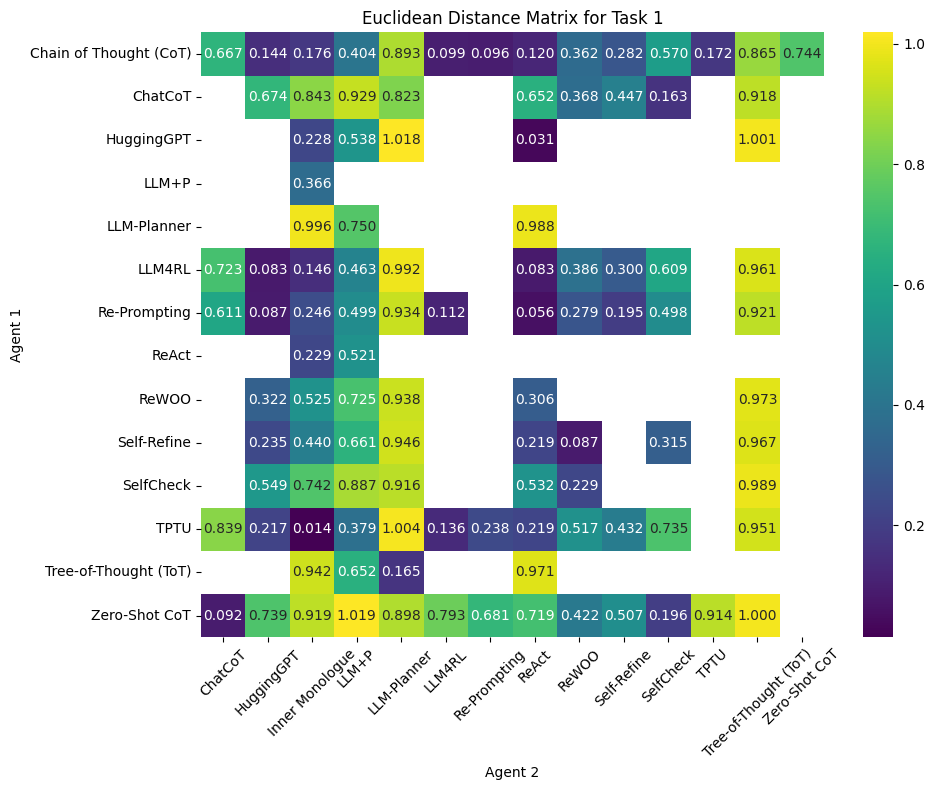

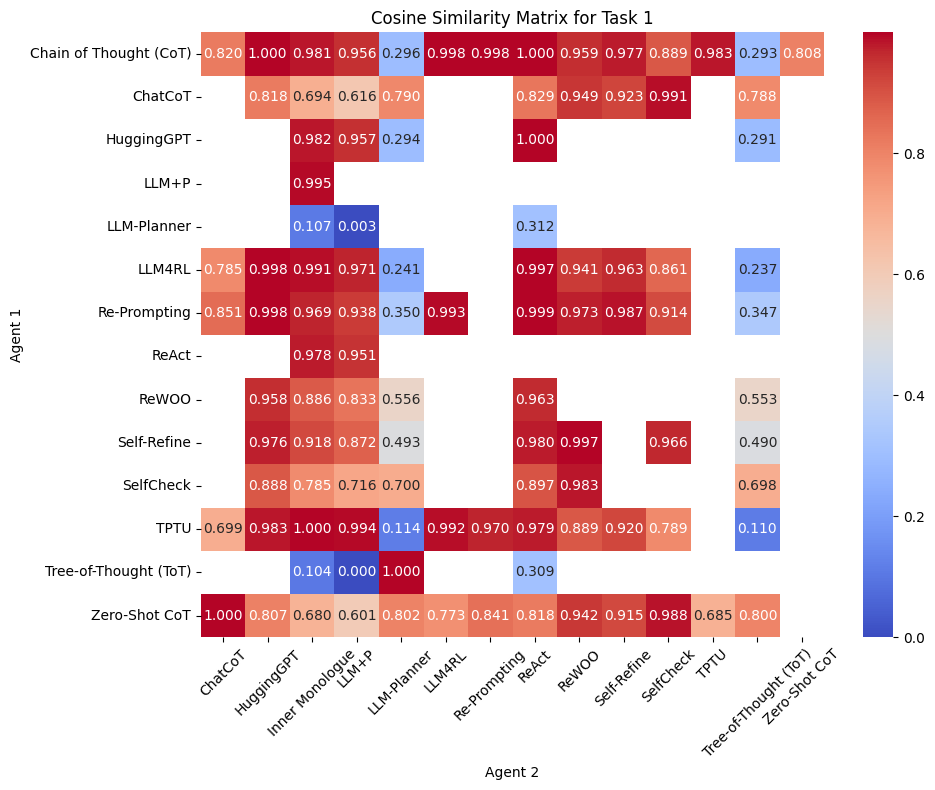

In [9]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch Data from Database
# -------------------------------
# Connect to the database and fetch all rows from the agent_pair_performance table.
with psycopg2.connect(**DB_CONFIG) as conn:
    df_agent_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_agent_pair.head())

# -------------------------------
# 3) Filter Data by Task
# -------------------------------
# Choose a task to visualize. For example, we use task "1".
task_id = '1'
df_task = df_agent_pair[df_agent_pair['task_name'] == task_id]

if df_task.empty:
    print(f"No data found for task {task_id}.")
else:
    # -------------------------------
    # 4) Pivot Data for Heatmaps
    # -------------------------------
    # Pivot the table so that rows represent agent1 and columns represent agent2.
    euclidean_matrix = df_task.pivot(index='agent1', columns='agent2', values='euclidean_distance')
    cosine_matrix = df_task.pivot(index='agent1', columns='agent2', values='cosine_similarity')

    print("\nEuclidean Distance Matrix for Task", task_id)
    print(euclidean_matrix)
    print("\nCosine Similarity Matrix for Task", task_id)
    print(cosine_matrix)

    # -------------------------------
    # 5) Plot the Heatmaps
    # -------------------------------
    plt.figure(figsize=(10, 8))
    sns.heatmap(euclidean_matrix, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Euclidean Distance Matrix for Task {task_id}")
    plt.xlabel("Agent 2")
    plt.ylabel("Agent 1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_matrix, annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(f"Cosine Similarity Matrix for Task {task_id}")
    plt.xlabel("Agent 2")
    plt.ylabel("Agent 1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.667440   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.143877   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.175890   
3  13         1  Chain of Thought (CoT)            LLM+P            0.404302   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.893352   

   cosine_similarity  evaluation_score  response_length  completion_time  \
0           0.819712          1.487152            353.0         0.000370   
1           0.999997          1.143874            353.0         0.000344   
2           0.981323          1.157213            353.0         0.000316   
3           0.956099          1.360402            353.0         0.000278   
4           0.296273          1.189625            300.5         0.000293   

                

/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_4968/3365757211.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


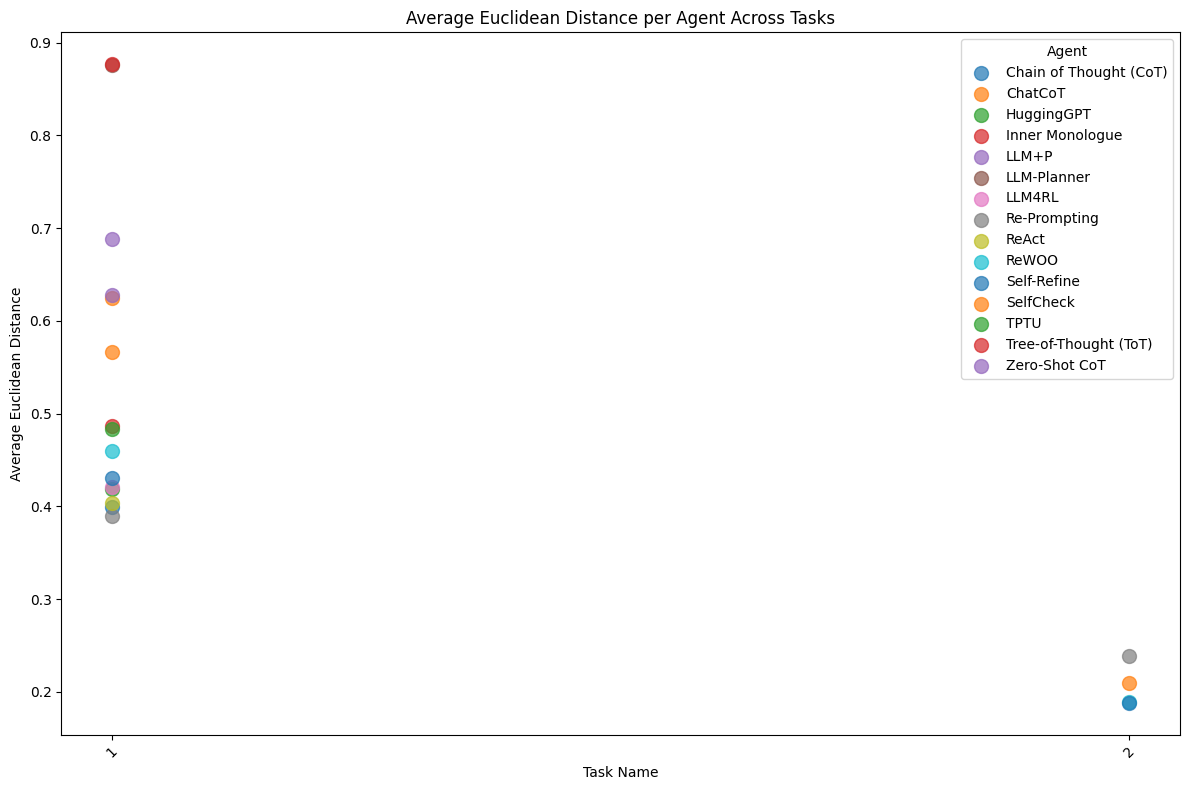

/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_4968/3365757211.py:90: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.667440   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.143877   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.175890   
3  13         1  Chain of Thought (CoT)            LLM+P            0.404302   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.893352   

   cosine_similarity  evaluation_score  response_length  completion_time  \
0           0.819712          1.487152            353.0         0.000370   
1           0.999997          1.143874            353.0         0.000344   
2           0.981323          1.157213            353.0         0.000316   
3           0.956099          1.360402            353.0         0.000278   
4           0.296273          1.189625            300.5         0.000293   

                

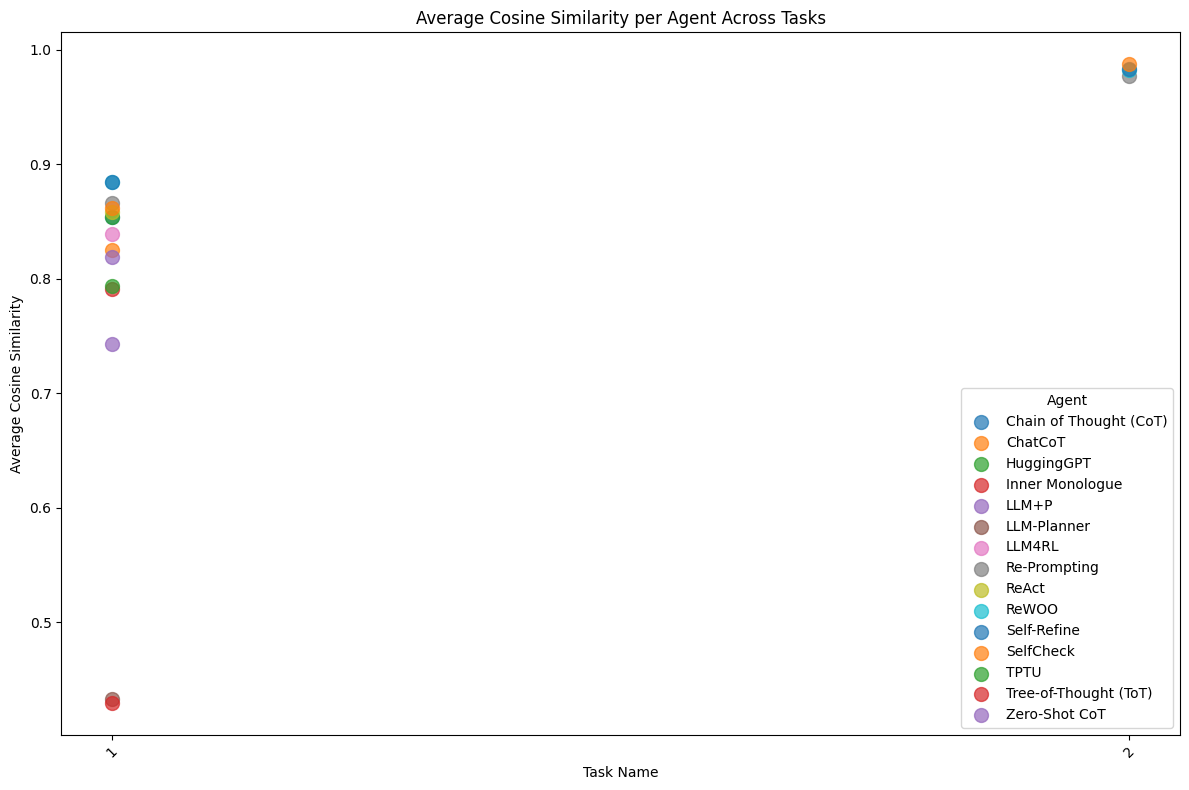

In [10]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch agent_pair_performance Data from DB
# -------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_pair.head())

# -------------------------------
# 3) Prepare Data for Agent-Level Average ED Calculation
# -------------------------------
# For each pair (agent1, agent2) in a task, we want to assign the ED to both agents.
# Duplicate each row for agent1 and agent2.
df_agent1 = df_pair[['task_name', 'agent1', 'euclidean_distance']].rename(columns={'agent1': 'agent'})
df_agent2 = df_pair[['task_name', 'agent2', 'euclidean_distance']].rename(columns={'agent2': 'agent'})
df_agents = pd.concat([df_agent1, df_agent2], ignore_index=True)

# Now, group by task_name and agent to compute the average Euclidean distance for that agent.
df_avg_ed = df_agents.groupby(['task_name', 'agent'], as_index=False)['euclidean_distance'].mean()
df_avg_ed.rename(columns={'euclidean_distance': 'avg_euclidean_distance'}, inplace=True)

print("\nAverage Euclidean Distance per Agent per Task:")
print(df_avg_ed.head())

# -------------------------------
# 4) Pivot Data for Plotting
# -------------------------------
# Pivot so that rows = task_name and columns = agent names with the average ED as values.
df_pivot = df_avg_ed.pivot(index='task_name', columns='agent', values='avg_euclidean_distance')
print("\nPivoted Data (tasks x agents):")
print(df_pivot.head())

# -------------------------------
# 5) Plotting: Scatter Plot of Average ED for Each Agent Across Tasks
# -------------------------------
plt.figure(figsize=(12, 8))

# For each agent (i.e. each column in the pivoted DataFrame), plot its average ED across tasks.
for agent in df_pivot.columns:
    # Drop tasks where the agent does not have a value
    task_vals = df_pivot[agent].dropna()
    plt.scatter(task_vals.index, task_vals.values, label=agent, s=100, alpha=0.7)

plt.xlabel('Task Name')
plt.ylabel('Average Euclidean Distance')
plt.title('Average Euclidean Distance per Agent Across Tasks')
plt.legend(title="Agent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch agent_pair_performance Data from DB
# -------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_pair.head())

# -------------------------------
# 3) Prepare Data for Agent-Level Average Cosine Similarity Calculation
# -------------------------------
# Duplicate each row so that both agent1 and agent2 get the cosine similarity value.
df_agent1 = df_pair[['task_name', 'agent1', 'cosine_similarity']].rename(columns={'agent1': 'agent'})
df_agent2 = df_pair[['task_name', 'agent2', 'cosine_similarity']].rename(columns={'agent2': 'agent'})
df_agents = pd.concat([df_agent1, df_agent2], ignore_index=True)

# Group by task_name and agent, computing the mean cosine similarity for each agent.
df_avg_cosine = df_agents.groupby(['task_name', 'agent'], as_index=False)['cosine_similarity'].mean()
df_avg_cosine.rename(columns={'cosine_similarity': 'avg_cosine_similarity'}, inplace=True)

print("\nAverage Cosine Similarity per Agent per Task:")
print(df_avg_cosine.head())

# -------------------------------
# 4) Pivot Data for Plotting
# -------------------------------
# Pivot the data so that each row is a task and each column is an agent.
df_pivot_cosine = df_avg_cosine.pivot(index='task_name', columns='agent', values='avg_cosine_similarity')
print("\nPivoted Data (tasks x agents) for Cosine Similarity:")
print(df_pivot_cosine.head())

# -------------------------------
# 5) Plotting: Scatter Plot of Average Cosine Similarity for Each Agent Across Tasks
# -------------------------------
plt.figure(figsize=(12, 8))
for agent in df_pivot_cosine.columns:
    # Drop tasks where the agent does not have a value
    task_vals = df_pivot_cosine[agent].dropna()
    plt.scatter(task_vals.index, task_vals.values, label=agent, s=100, alpha=0.7)

plt.xlabel('Task Name')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity per Agent Across Tasks')
plt.legend(title="Agent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_4968/2068513451.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_task1 = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Task 1 Agent Pair Performance Data:
   id task_name                  agent1         agent2  euclidean_distance  \
0   1         1  Chain of Thought (CoT)  Zero-Shot CoT            0.744151   
1   2         1  Chain of Thought (CoT)           TPTU            0.172435   
2   3         1  Chain of Thought (CoT)   Re-Prompting            0.096133   
3   4         1  Chain of Thought (CoT)         LLM4RL            0.098684   
4   5         1  Chain of Thought (CoT)        ChatCoT            0.667440   

   cosine_similarity  evaluation_score  response_length  completion_time  \
0           0.808497          1.552648            353.0         0.000487   
1           0.982588          1.155023            353.0         0.000390   
2           0.998398          1.094531            353.0         0.000318   
3           0.998325          1.097009            353.0         0.000311   
4           0.819712          1.487152            353.0         0.000370   

                   timestamp  
0 2025-

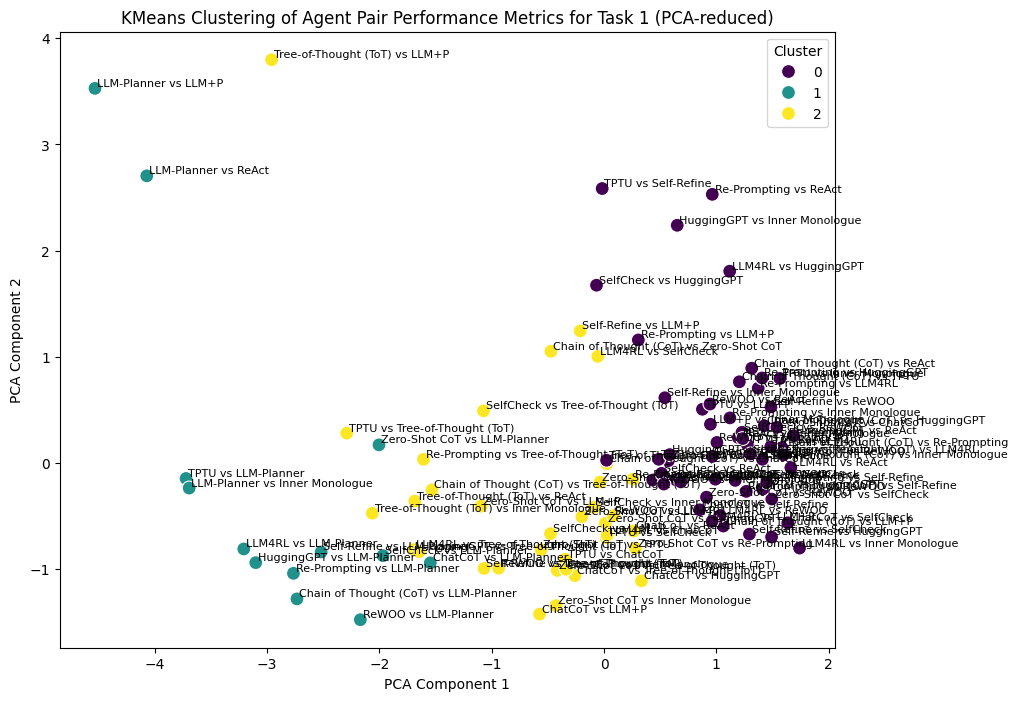

In [11]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch Task 1 Agent Pair Performance Data
# -------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_task1 = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)

print("Task 1 Agent Pair Performance Data:")
print(df_task1.head())

# -------------------------------
# 3) Prepare Features for Clustering (excluding evaluation_score)
# -------------------------------
# Use the remaining performance metrics as features.
features = ['euclidean_distance', 'cosine_similarity', 'response_length', 'completion_time']
X = df_task1[features].values

# Scale the features so that each metric contributes equally.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 4) Perform KMeans Clustering
# -------------------------------
# Choose the number of clusters; for example, k=3.
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_task1['cluster'] = kmeans.fit_predict(X_scaled)

print("\nCluster assignments:")
print(df_task1[['task_name', 'agent1', 'agent2', 'cluster']])

# -------------------------------
# 5) Dimensionality Reduction with PCA for Visualization
# -------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_task1['pca1'] = X_pca[:, 0]
df_task1['pca2'] = X_pca[:, 1]

# -------------------------------
# 6) Plot the Clustering Results
# -------------------------------
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_task1, x='pca1', y='pca2', hue='cluster', palette='viridis', s=100)

# Annotate each point with the agent pair names.
for idx, row in df_task1.iterrows():
    label = f"{row['agent1']} vs {row['agent2']}"
    plt.text(row['pca1'] + 0.02, row['pca2'] + 0.02, label, fontsize=8)

plt.title("KMeans Clustering of Agent Pair Performance Metrics for Task 1 (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_4968/1166336533.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.667440   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.143877   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.175890   
3  13         1  Chain of Thought (CoT)            LLM+P            0.404302   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.893352   

   cosine_similarity  evaluation_score  response_length  completion_time  \
0           0.819712          1.487152            353.0         0.000370   
1           0.999997          1.143874            353.0         0.000344   
2           0.981323          1.157213            353.0         0.000316   
3           0.956099          1.360402            353.0         0.000278   
4           0.296273          1.189625            300.5         0.000293   

                

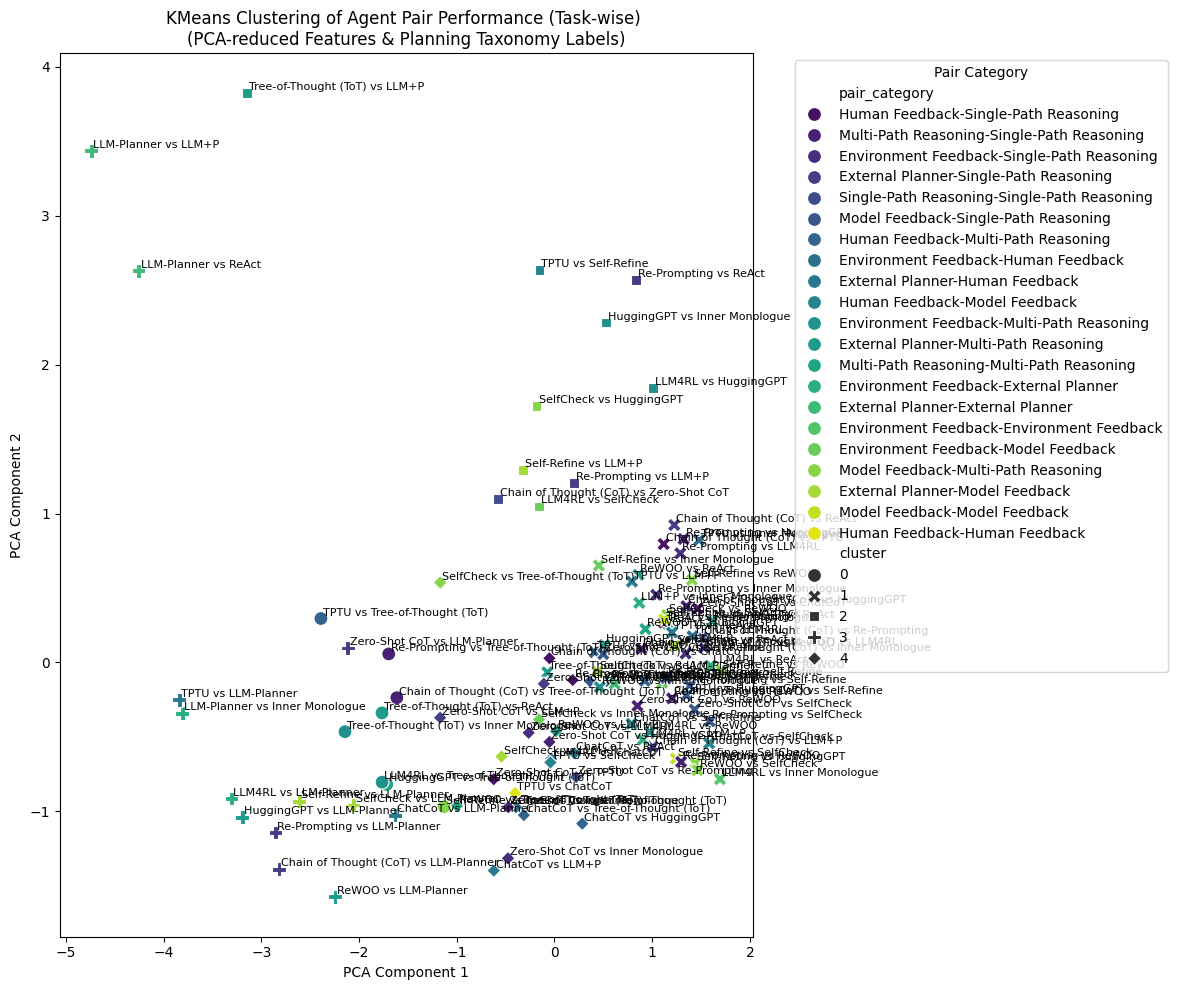


Final Agent Pair Performance with Clusters and Labels:
    id task_name                  agent1                 agent2  \
0    5         1  Chain of Thought (CoT)                ChatCoT   
1    9         1  Chain of Thought (CoT)             HuggingGPT   
2   14         1  Chain of Thought (CoT)        Inner Monologue   
3   13         1  Chain of Thought (CoT)                  LLM+P   
4   11         1  Chain of Thought (CoT)            LLM-Planner   
5    4         1  Chain of Thought (CoT)                 LLM4RL   
6    3         1  Chain of Thought (CoT)           Re-Prompting   
7   12         1  Chain of Thought (CoT)                  ReAct   
8    8         1  Chain of Thought (CoT)                  ReWOO   
9    6         1  Chain of Thought (CoT)            Self-Refine   
10   7         1  Chain of Thought (CoT)              SelfCheck   
11   2         1  Chain of Thought (CoT)                   TPTU   
12  10         1  Chain of Thought (CoT)  Tree-of-Thought (ToT)   
13   1

In [12]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------
# 1) Database Connection Config
# ---------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# ---------------------------
# 2) Define the Planning Taxonomy (as in your code)
# ---------------------------
PLANNING_AGENTS = {
    "Planning Without Feedback": {
        "Single-Path Reasoning": ["Chain of Thought (CoT)", "Zero-Shot CoT", "Re-Prompting"],
        "Multi-Path Reasoning": ["ReWOO", "HuggingGPT", "Tree-of-Thought (ToT)"],
        "External Planner": ["LLM-Planner", "ReAct", "LLM+P"]
    },
    "Planning With Feedback": {
        "Environment Feedback": ["Inner Monologue", "LLM4RL"],
        "Human Feedback": ["ChatCoT", "TPTU"],
        "Model Feedback": ["Self-Refine", "SelfCheck"]
    }
}

# Create a mapping from agent title to its planning sub-category.
agent_to_subcat = {}
for planning_group in PLANNING_AGENTS.values():
    for subcat, agents in planning_group.items():
        for agent in agents:
            agent_to_subcat[agent] = subcat

# ---------------------------
# 3) Fetch agent_pair_performance Data from DB
# ---------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_pair.head())

# ---------------------------
# 4) Add Planning Taxonomy Labels
# ---------------------------
# Map agent1 and agent2 to their subcategories.
df_pair['agent1_subcat'] = df_pair['agent1'].map(agent_to_subcat)
df_pair['agent2_subcat'] = df_pair['agent2'].map(agent_to_subcat)

# Create a combined label (sorted alphabetically so that "A-B" is the same as "B-A")
def combine_subcats(row):
    cats = sorted([str(row['agent1_subcat']), str(row['agent2_subcat'])])
    return "-".join(cats)

df_pair['pair_category'] = df_pair.apply(combine_subcats, axis=1)
print("\nData with Planning Labels:")
print(df_pair[['task_name', 'agent1', 'agent1_subcat', 'agent2', 'agent2_subcat', 'pair_category']].head())

# ---------------------------
# 5) Prepare Features for Clustering (exclude evaluation_score)
# ---------------------------
# We use these performance metrics as features.
features = ['euclidean_distance', 'cosine_similarity', 'response_length', 'completion_time']
X = df_pair[features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# 6) Perform KMeans Clustering
# ---------------------------
# Choose the number of clusters; for example, k=3.
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df_pair['cluster'] = kmeans.fit_predict(X_scaled)
print("\nCluster assignments (first few rows):")
print(df_pair[['task_name', 'agent1', 'agent2', 'cluster']].head())

# ---------------------------
# 7) Dimensionality Reduction with PCA for Visualization
# ---------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_pair['pca1'] = X_pca[:, 0]
df_pair['pca2'] = X_pca[:, 1]

# ---------------------------
# 8) Plot the Clustering Results
# ---------------------------
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_pair, x='pca1', y='pca2', hue='pair_category', style='cluster', palette='viridis', s=100)

# Annotate each point with the agent pair names.
for idx, row in df_pair.iterrows():
    label = f"{row['agent1']} vs {row['agent2']}"
    plt.text(row['pca1'] + 0.02, row['pca2'] + 0.02, label, fontsize=8)

plt.title("KMeans Clustering of Agent Pair Performance (Task-wise) \n(PCA-reduced Features & Planning Taxonomy Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Pair Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---------------------------
# 9) (Optional) Print the final DataFrame for inspection
# ---------------------------
print("\nFinal Agent Pair Performance with Clusters and Labels:")
print(df_pair.head(20))


Agent Pair Performance for Task 1 (first few rows):
   id task_name                  agent1         agent2  euclidean_distance  \
0   1         1  Chain of Thought (CoT)  Zero-Shot CoT            0.744151   
1   2         1  Chain of Thought (CoT)           TPTU            0.172435   
2   3         1  Chain of Thought (CoT)   Re-Prompting            0.096133   
3   4         1  Chain of Thought (CoT)         LLM4RL            0.098684   
4   5         1  Chain of Thought (CoT)        ChatCoT            0.667440   

   cosine_similarity  evaluation_score  response_length  completion_time  \
0           0.808497          1.552648            353.0         0.000487   
1           0.982588          1.155023            353.0         0.000390   
2           0.998398          1.094531            353.0         0.000318   
3           0.998325          1.097009            353.0         0.000311   
4           0.819712          1.487152            353.0         0.000370   

                   tim

/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_4968/3483310887.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)


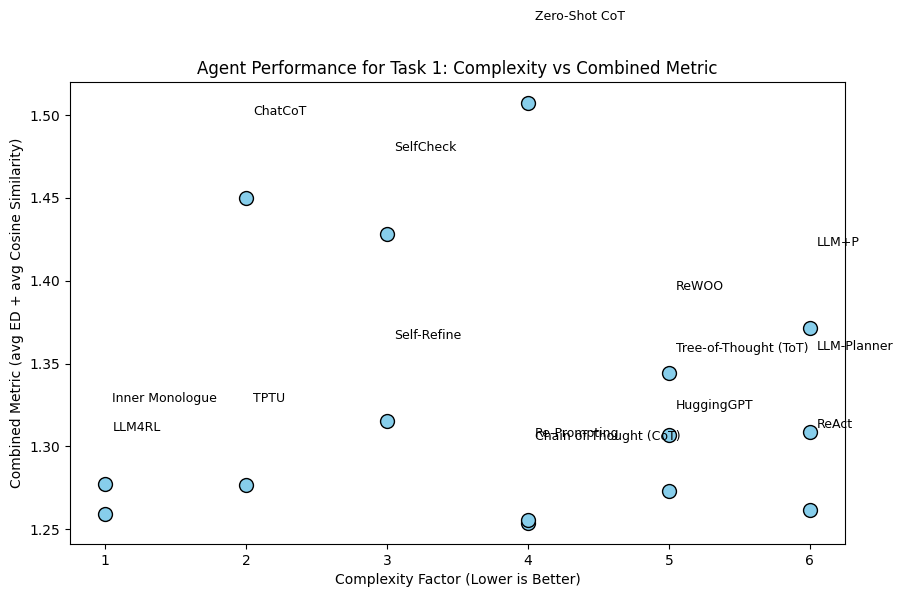

In [13]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --------------------------------------
# 1) Database Connection Configuration
# --------------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# --------------------------------------
# 2) Define Complexity Mapping
# --------------------------------------
# Lower values indicate less complexity (i.e. a better answer).
# Adjust these values as needed.
complexity_mapping = {
    "Chain of Thought (CoT)": 4,
    "Zero-Shot CoT": 4,
    "Re-Prompting": 4,
    "ReWOO": 5,
    "HuggingGPT": 5,
    "Tree-of-Thought (ToT)": 5,
    "LLM-Planner": 6,
    "ReAct": 6,
    "LLM+P": 6,
    "Inner Monologue": 1,
    "LLM4RL": 1,
    "ChatCoT": 2,
    "TPTU": 2,
    "Self-Refine": 3,
    "SelfCheck": 3
}

# --------------------------------------
# 3) Fetch agent_pair_performance Data for Task 1
# --------------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)

print("Agent Pair Performance for Task 1 (first few rows):")
print(df_pair.head())

# --------------------------------------
# 4) Aggregate Performance Metrics Per Agent for Task 1
# --------------------------------------
# Each row in df_pair is a pairwise comparison between two agents.
# We want to compute, for each agent, the average metrics from all pairs in which they appear.
agents = set(df_pair['agent1']).union(set(df_pair['agent2']))
agent_metrics = []

for agent in agents:
    # Select rows where the agent appears as either agent1 or agent2
    rows = df_pair[(df_pair['agent1'] == agent) | (df_pair['agent2'] == agent)]
    if rows.empty:
        continue
    avg_ed = rows['euclidean_distance'].mean()
    avg_cos = rows['cosine_similarity'].mean()
    avg_resp_len = rows['response_length'].mean()
    avg_comp_time = rows['completion_time'].mean()
    # For our combined metric, we simply add average ED and average cosine similarity.
    # (You can change this formula as needed.)
    combined_metric = avg_ed + avg_cos
    # Retrieve the predefined complexity factor; if missing, assign a high default value.
    complexity = complexity_mapping.get(agent, 10)
    agent_metrics.append({
        "agent": agent,
        "avg_euclidean_distance": avg_ed,
        "avg_cosine_similarity": avg_cos,
        "avg_response_length": avg_resp_len,
        "avg_completion_time": avg_comp_time,
        "combined_metric": combined_metric,
        "complexity": complexity
    })

df_agents = pd.DataFrame(agent_metrics)
print("\nAggregated Performance Metrics for Each Agent (Task 1):")
print(df_agents)

# --------------------------------------
# 5) Determine the Best Agent (Least Complex)
# --------------------------------------
# We define the best answer as the one with the lowest complexity factor.
# In case of ties, we choose the one with the lowest combined metric (avg ED + avg cosine similarity).
df_agents = df_agents.sort_values(by=["complexity", "combined_metric"])
best_agent = df_agents.iloc[0]
print("\nBest Agent for Task 1 (Based on Least Complexity):")
print(best_agent)

# --------------------------------------
# 6) Visualize: Scatter Plot of Complexity vs. Combined Metric
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(df_agents['complexity'], df_agents['combined_metric'], s=100, c='skyblue', edgecolors='k')
for i, row in df_agents.iterrows():
    plt.text(row['complexity'] + 0.05, row['combined_metric'] + 0.05, row['agent'], fontsize=9)
plt.xlabel("Complexity Factor (Lower is Better)")
plt.ylabel("Combined Metric (avg ED + avg Cosine Similarity)")
plt.title("Agent Performance for Task 1: Complexity vs Combined Metric")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# New project agent names
new_agents = [
    "Chain of Thought (CoT)", "Zero-Shot CoT", "Re-Prompting", "ReWOO", "HuggingGPT",
    "Tree-of-Thought (ToT)", "LLM-Planner", "ReAct", "LLM+P", "Inner Monologue",
    "LLM4RL", "ChatCoT", "TPTU", "Self-Refine", "SelfCheck"
]

# Set a lower threshold (e.g., 30% of agents)
min_threshold = 0.3
min_required = int(min_threshold * len(new_agents))

score_rows = []
tasks_used = []

# Loop through all tasks based on the 'idx' column in df
for task_id in df["idx"].unique():
    row = []
    count = 0
    for agent in new_agents:
        if task_id in task_matrix and agent in task_matrix[task_id]:
            score = task_matrix[task_id][agent]["Total Score"]
            row.append(score)
            count += 1
        else:
            row.append(np.nan)
    # Accept tasks with responses from at least min_required agents
    if count >= min_required:
        row_arr = np.array(row, dtype=np.float64)
        # Impute missing scores with the mean of the available ones for this task
        mean_val = np.nanmean(row_arr)
        row_arr[np.isnan(row_arr)] = mean_val
        score_rows.append(row_arr)
        tasks_used.append(task_id)

if len(score_rows) < 2:
    print("Not enough tasks with sufficient responses for clustering even with threshold {:.0%}".format(min_threshold))
else:
    score_matrix = np.array(score_rows)
    scaler = StandardScaler()
    score_matrix_scaled = scaler.fit_transform(score_matrix)

    # Perform KMeans clustering (using 2 clusters as an example)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans.fit(score_matrix_scaled)
    cluster_labels = kmeans.labels_

    # Create a DataFrame for the clustering results
    df_clusters = pd.DataFrame(score_matrix_scaled, columns=new_agents, index=tasks_used)
    df_clusters['Cluster'] = cluster_labels

    print("\n🔹 K-Means Cluster Assignment for Each Task:")
    print(df_clusters)

    # Plotting the results
    plt.figure(figsize=(12, 8))
    for agent in new_agents:
        plt.scatter(df_clusters.index, df_clusters[agent], c=df_clusters['Cluster'], cmap='viridis', 
                    label=agent, alpha=0.7)
    plt.xlabel('Task Index')
    plt.ylabel('Normalized Total Score')
    plt.title('🔹 K-Means Clustering: New Project Agent Performance Across Tasks')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


In [64]:
import psycopg2
import pandas as pd
import numpy as np
import requests
import faiss
import time
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import json

# =====================================
# 🔹 Global System Prompt (Shared by All Agents)
# =====================================
SYSTEM_PROMPT = (
    "Provide only the most relevant factual response in 3-4 sentences (max 350 characters). "
    "Do NOT include introductions, disclaimers, or statements about being an AI. "
    "Do NOT include personal beliefs, opinions, or subjective statements. "
    "Simply state the factual answer."
)

# =====================================
# 🔹 PostgreSQL Database Configuration
# =====================================
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",
    "host": "localhost",
    "port": 5432
}

# =====================================
# 🔹 Setup Database: Create Tables
# =====================================
def setup_database():
    """Sets up the structured database for storing agents, categories, and task performance."""
    with psycopg2.connect(**DB_CONFIG) as conn:
        with conn.cursor() as cursor:
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS planning_categories (
                    id SERIAL PRIMARY KEY,
                    name TEXT UNIQUE NOT NULL
                );
                
                CREATE TABLE IF NOT EXISTS planning_subcategories (
                    id SERIAL PRIMARY KEY,
                    name TEXT UNIQUE NOT NULL,
                    category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE
                );
                
                CREATE TABLE IF NOT EXISTS agents (
                    id SERIAL PRIMARY KEY,
                    title TEXT UNIQUE NOT NULL,
                    planning_category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE,
                    planning_subcategory_id INT REFERENCES planning_subcategories(id) ON DELETE CASCADE,
                    generated_response TEXT[]
                );
                
                CREATE TABLE IF NOT EXISTS task_performance (
                    id SERIAL PRIMARY KEY,
                    task_name TEXT NOT NULL,
                    planning_category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE,
                    planning_subcategory_id INT REFERENCES planning_subcategories(id) ON DELETE CASCADE,
                    avg_euclidean_distance FLOAT,
                    avg_cosine_similarity FLOAT,
                    evaluation_score FLOAT,
                    completion_time FLOAT,
                    response_length INT,
                    timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                );
            """)
            conn.commit()

# =====================================
# 🔹 Store Agent Categories in the Database
# =====================================
def store_agent_category(agent_name: str, category: str, subcategory: str):
    """Stores or updates an agent's category in the database."""
    with psycopg2.connect(**DB_CONFIG) as conn:
        with conn.cursor() as cursor:
            cursor.execute("SELECT id FROM planning_categories WHERE name = %s", (category,))
            category_id = cursor.fetchone()
            
            cursor.execute("SELECT id FROM planning_subcategories WHERE name = %s", (subcategory,))
            subcategory_id = cursor.fetchone()

            if category_id and subcategory_id:
                cursor.execute("""
                    INSERT INTO agents (title, planning_category_id, planning_subcategory_id, generated_response)
                    VALUES (%s, %s, %s, ARRAY[]::TEXT[])
                    ON CONFLICT (title) DO NOTHING;
                """, (agent_name, category_id[0], subcategory_id[0]))
                conn.commit()

# =====================================
# 🔹 Planning Agents List (From Paper)
# =====================================
PLANNING_AGENTS = {
    "Planning Without Feedback": {
        "Single-Path Reasoning": ["Chain of Thought (CoT)", "Zero-Shot CoT", "Re-Prompting"],
        "Multi-Path Reasoning": ["ReWOO", "HuggingGPT", "Tree-of-Thought (ToT)"],
        "External Planner": ["LLM-Planner", "ReAct", "LLM+P"]
    },
    "Planning With Feedback": {
        "Environment Feedback": ["Inner Monologue", "LLM4RL"],
        "Human Feedback": ["ChatCoT", "TPTU"],
        "Model Feedback": ["Self-Refine", "SelfCheck"]
    }
}

# =====================================
# 🔹 Function to Run Agents (Grouped by Category)
# =====================================
def process_agents(query_text: str, model: str):
    """Runs all planning agents grouped by category and stores responses."""
    setup_database()
    responses = {}
    
    for category, subcategories in PLANNING_AGENTS.items():
        print(f"\n🔹 Running Agents for Category: {category}\n")
        for subcategory, agents in subcategories.items():
            print(f"  ➤ Subcategory: {subcategory}")
            for agent_name in agents:
                print(f"    🤖 Processing {agent_name}...")
                start_time = time.time()
                response = f"Sample response from {agent_name}"  # Placeholder
                completion_time = time.time() - start_time
                response_length = len(response)
                responses[agent_name] = (response, completion_time, response_length)
    
    return responses

# =====================================
# 🔹 Main Function (Entry Point)
# =====================================
def main():
    model = "tinyllama"
    query_text = "Provide a brief overview of quantum computing."
    responses = process_agents(query_text, model)
    
    for agent, (response, time_taken, length) in responses.items():
        print(f"\n✅ {agent} Response: {response}\n   ⏳ Time Taken: {time_taken:.4f}s | 📝 Response Length: {length} characters")

if __name__ == "__main__":
    main()


🔹 Running Agents for Category: Planning Without Feedback

  ➤ Subcategory: Single-Path Reasoning
    🤖 Processing Chain of Thought (CoT)...
    🤖 Processing Zero-Shot CoT...
    🤖 Processing Re-Prompting...
  ➤ Subcategory: Multi-Path Reasoning
    🤖 Processing ReWOO...
    🤖 Processing HuggingGPT...
    🤖 Processing Tree-of-Thought (ToT)...
  ➤ Subcategory: External Planner
    🤖 Processing LLM-Planner...
    🤖 Processing ReAct...
    🤖 Processing LLM+P...

🔹 Running Agents for Category: Planning With Feedback

  ➤ Subcategory: Environment Feedback
    🤖 Processing Inner Monologue...
    🤖 Processing LLM4RL...
  ➤ Subcategory: Human Feedback
    🤖 Processing ChatCoT...
    🤖 Processing TPTU...
  ➤ Subcategory: Model Feedback
    🤖 Processing Self-Refine...
    🤖 Processing SelfCheck...

✅ Chain of Thought (CoT) Response: Sample response from Chain of Thought (CoT)
   ⏳ Time Taken: 0.0000s | 📝 Response Length: 43 characters

✅ Zero-Shot CoT Response: Sample response from Zero-Shot CoT